In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *

/home/mainak/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/mainak/.local/lib/python2.7/site-packages/pyneb/utils/manage_atomic_data.py:528: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  gsconf = np.genfromtxt(execution_path('../atomic_data/levels/gsconfs.dat'), names=['atom', 'gsconf'], dtype=None)


In [2]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>6750*k) & (wo_wave<6800*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [3]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave<5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 1
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=p_init,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

In [4]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='black',label='data',drawstyle='steps-mid',lw = 3)
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)",fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_data.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g----',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='--',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_BLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],'r-',label='data',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(wo_wave[select],fit,'r:',label='fit')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)

    fig = plt.gcf()
    fig.set_size_inches(9, 3)
    plt.plot(wo_wave[select],residual/error[select],drawstyle='steps-mid',color='black')
    plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Residual/Error",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_residual.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)


In [5]:
def central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    central_coordinates = [int(brightest_pixel_x),int(brightest_pixel_y)]
    print central_coordinates
    popt = np.append(popt_full_fit,central_coordinates)
    central_cordinates_err = [0,0]
    err = np.append(parameters_err,central_cordinates_err)
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'central_x':18,'central_y':19}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)



In [6]:
def algorithm_script(obj,p_init,z,broad2,prefix_path_cube="/home/mainak/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    print '%s'%(obj)
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption.fits'%(destination_path_cube,obj,obj)) 
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]
    print brightest_pixel_x,brightest_pixel_y
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    print factor
    error = factor*error
    #print (~np.isnan(error)).sum(0)
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2)
    print popt_full_fit,parameters_err
    plot(obj,wo_wave,data,error,z,popt_full_fit,broad2)
    central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err)

HE0345+0056
79 80
2.5746026
[5.23093776e-01 1.73527465e+01 9.17874013e+03 1.62294762e+02
 4.73921414e+00 1.12990477e+01 8.84499625e+03 3.96174485e+02
 2.75339892e+01 2.62301847e+00 9.34420403e+03 3.26281307e+02
 8.90110676e+00 1.81714065e+00 9.34453090e+03 1.56270959e+03
 4.23286044e-01 6.76582562e+00] [ 0.8433586   0.36431091  3.50979649  5.23809584  0.34332554  0.33091819
 11.00043933  4.89547567  0.67834624  0.068646    6.1918029   4.7000706
  0.15126395  0.05545055 12.45450603 20.84836549  0.13340628  0.68147282]


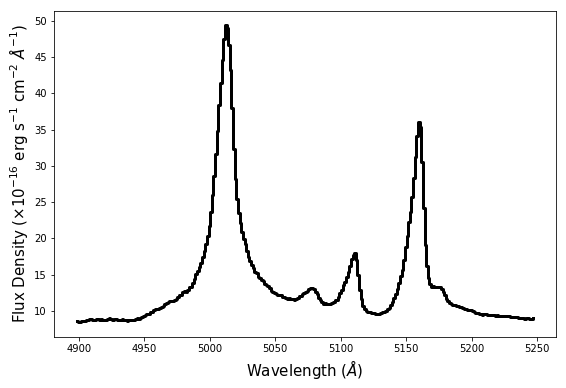

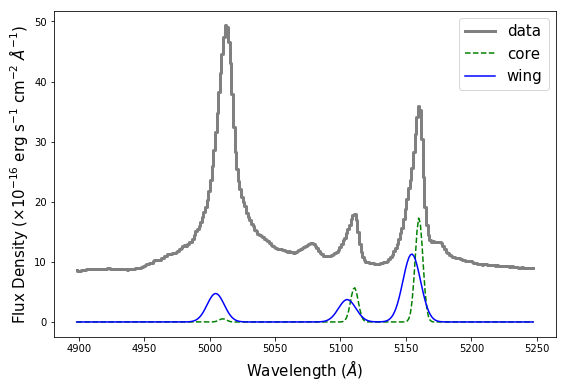

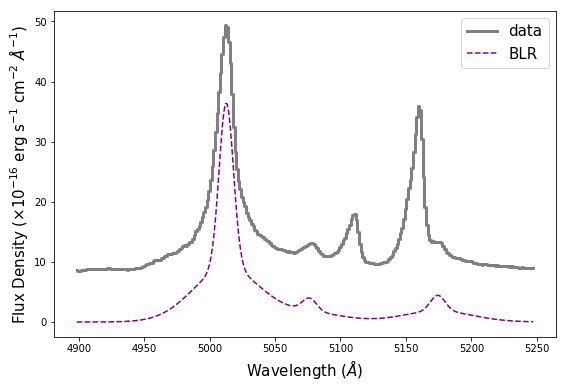

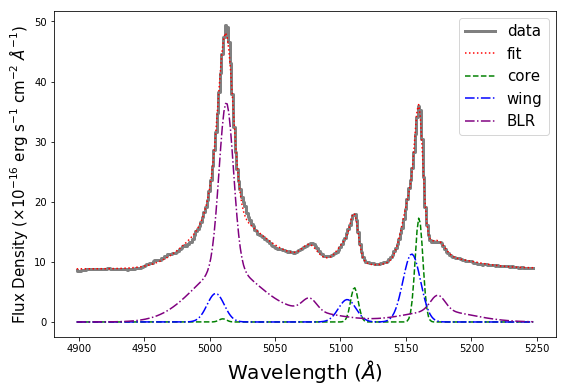

/home/mainak/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


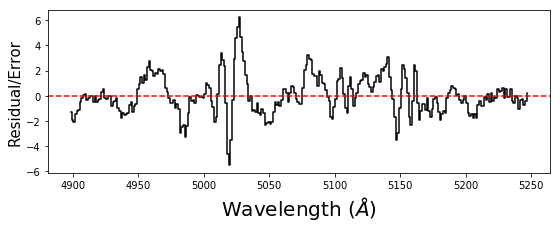

[79, 80]
HE0412-0803
179 160
1.4854273
[ 1.62569878e+00  2.26845818e+01  1.14673641e+04  9.17543211e+01
  5.63655373e-01  4.33686103e+00  1.14592653e+04  2.76690171e+02
  1.55393820e+00  2.35571914e-01  1.13036277e+04  1.82277840e+03
  0.00000000e+00  0.00000000e+00  1.14480000e+04  1.00000000e+03
 -2.26517843e-01  2.15556794e+00] [7.05484413e-02 2.26909508e-01 7.71957435e-01 2.10158453e+00
 5.14905482e-02 2.52249693e-01 2.26925620e+00 5.95317116e+00
 1.17295970e-02 8.04318514e-03 1.23758898e+01 1.24230033e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.73974410e-02 8.81189317e-02]


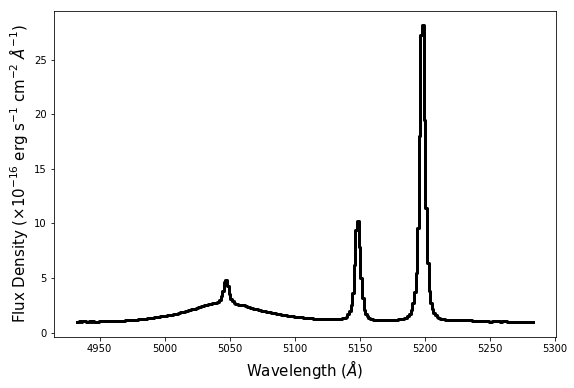

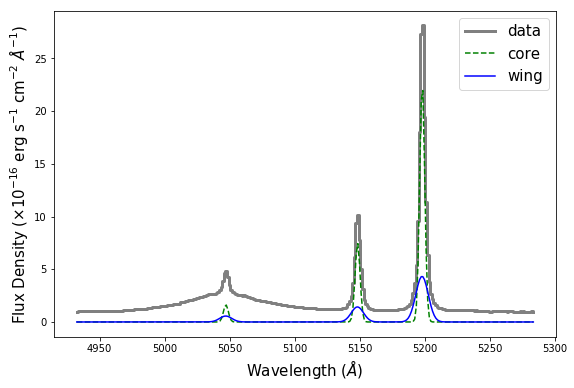

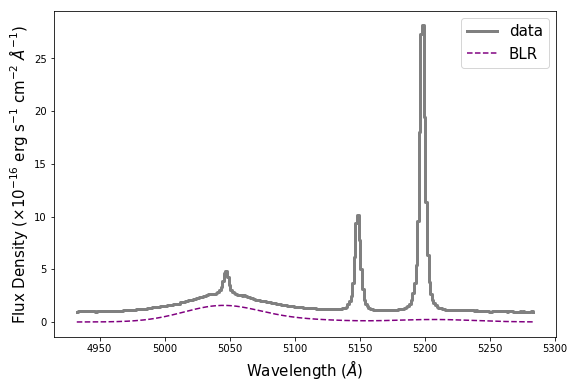

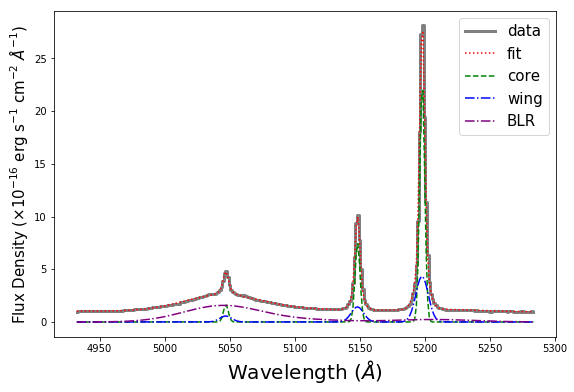

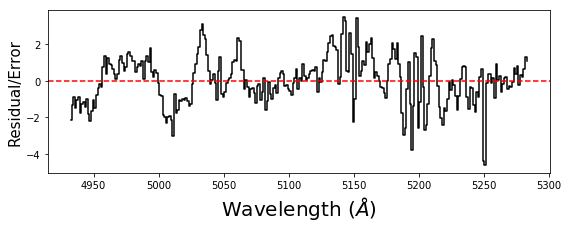

[179, 160]
HE0224-2834
81 77
1.412135
[ 1.93539690e-01  2.36670077e+00  1.79897243e+04  1.06972679e+02
  8.31277044e-02  9.74385002e-01  1.79642305e+04  2.60281796e+02
  3.49398761e-01  5.25790646e-02  1.79929978e+04  2.16626763e+03
  0.00000000e+00  0.00000000e+00  1.79400000e+04  1.50000000e+03
 -7.76167516e-02  7.84615197e-01] [2.16392017e-02 8.42439052e-02 1.22738635e+00 3.68894680e+00
 1.75342473e-02 9.03001091e-02 4.33548413e+00 9.00302552e+00
 3.12086361e-03 3.32723529e-03 2.59667854e+01 2.37903990e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.86607607e-03 5.15420390e-02]


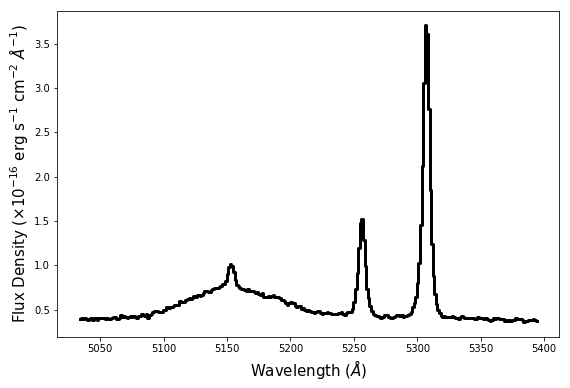

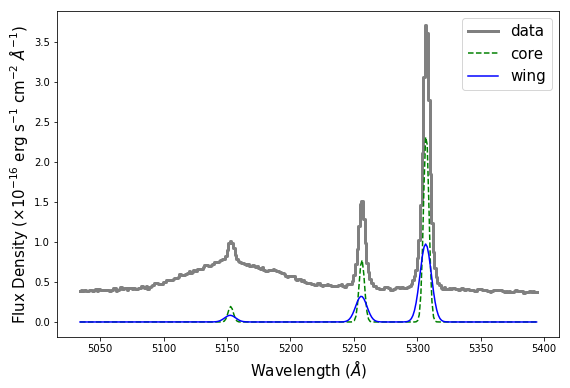

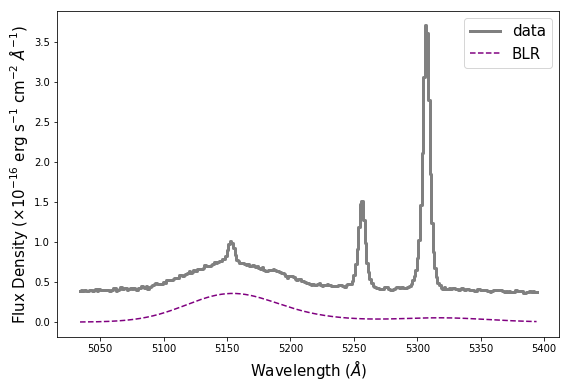

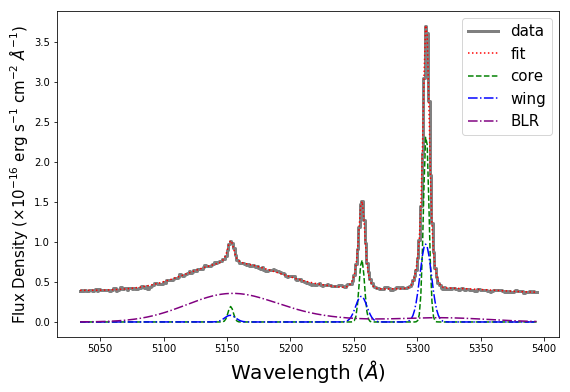

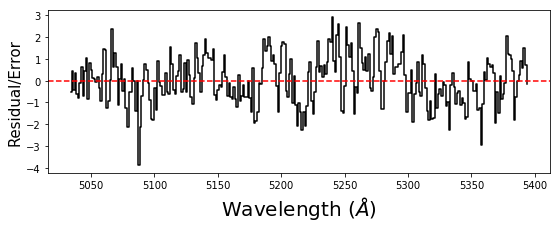

[81, 77]
HE0433-1028
150 157
1.609308
[ 6.29509689e-01  4.33436175e+00  1.05792843e+04  1.29672467e+02
  5.45605131e-01  4.89411382e+00  1.02691776e+04  3.30583880e+02
  2.40672027e+00  2.60273108e-01  1.05122268e+04  9.75016290e+02
  1.07907010e+00  3.05064279e-01  1.13343778e+04  2.14628544e+03
 -6.76493041e-01  5.23601528e+00] [6.40015476e-02 1.11116733e-01 4.51391160e+00 5.34485636e+00
 1.12671001e-01 1.08300591e-01 6.56023435e+00 2.63988255e+00
 1.66743917e-01 7.49424680e-02 3.52953964e+01 7.47628458e+01
 2.36251630e-01 2.86630220e-02 1.31530947e+03 5.31921366e+02
 1.47333172e-01 7.53116129e-01]


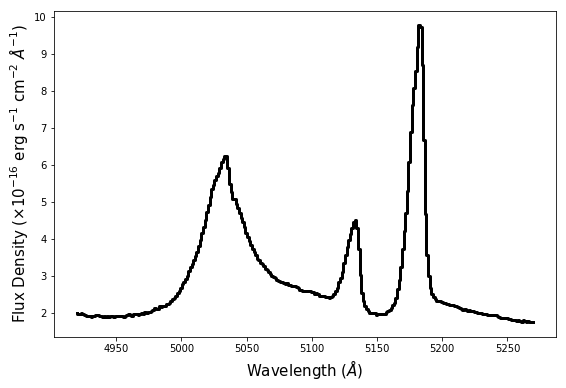

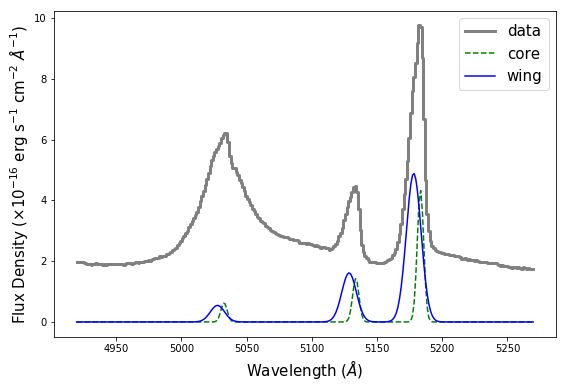

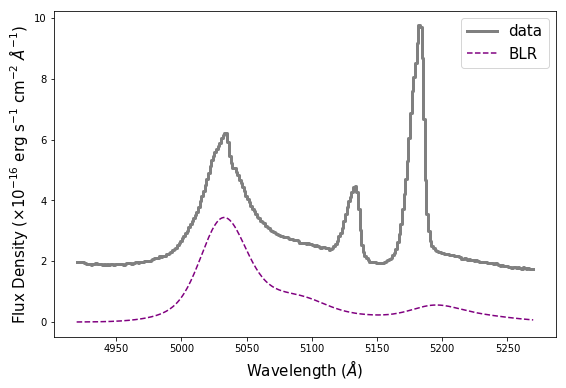

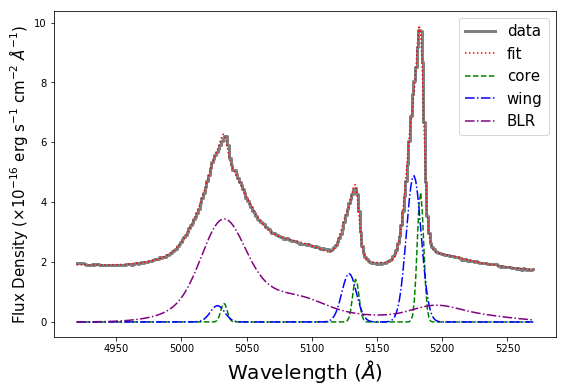

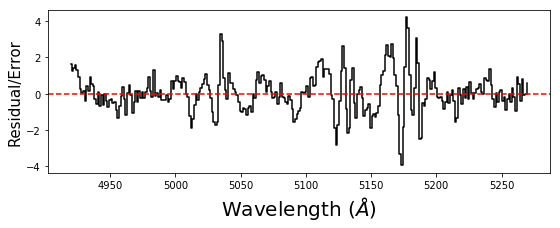

[150, 157]
HE2233+0124
34 82
2.707773
[8.91783145e-02 8.98206236e-01 1.69856743e+04 1.74211197e+02
 5.13521148e-02 1.41959335e-01 1.70378664e+04 5.36575109e+02
 1.43879363e-01 3.70561482e-05 1.52047187e+04 1.30765217e+03
 2.12706225e-01 9.42838662e-03 1.86443366e+04 4.29732511e+03
 2.06755111e-03 2.58942261e-01] [3.16765780e-02 1.95234022e-01 8.54588992e+00 3.92168939e+01
 3.22841220e-02 2.06527146e-01 4.05074499e+01 1.45550716e+02
 5.52735207e-02 1.68340202e-02 6.20127659e+02 2.84998245e+02
 3.60448990e-02 3.44806045e-02 9.75727343e+02 5.95513978e+02
 1.48997127e-01 7.85899084e-01]


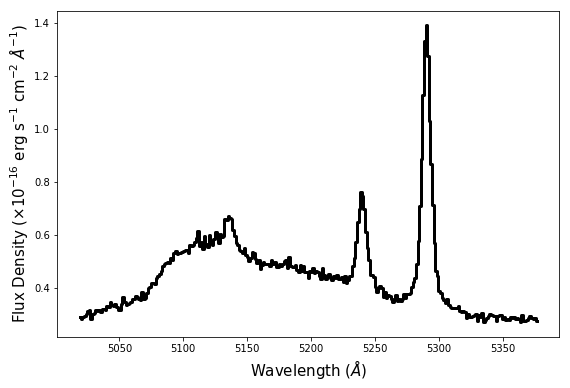

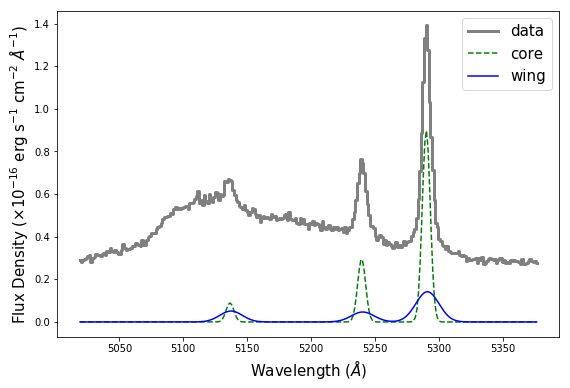

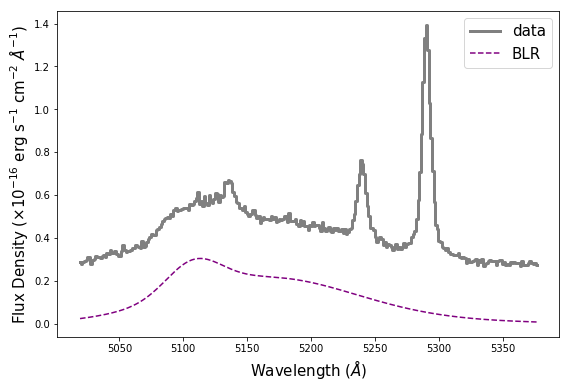

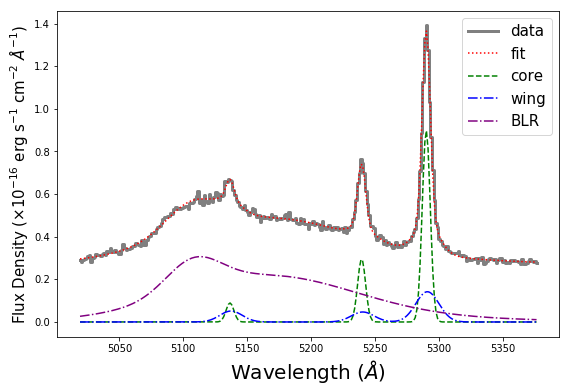

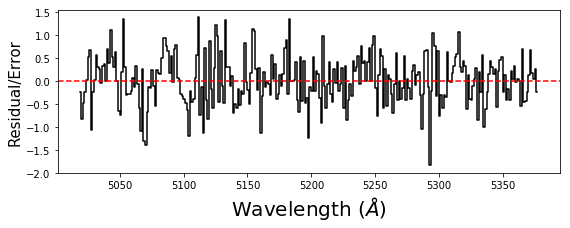

[34, 82]
HE1330-1013
157 160
1.036044
[ 1.19745382e-01  5.61328543e-01  6.74250778e+03  7.83251391e+01
  6.13460284e-02  1.63733433e-01  6.58670246e+03  2.11776429e+02
  1.35439287e-01  5.83665767e-02  6.96871099e+03  1.89442503e+03
  2.89929810e-01  3.42128124e-02  6.82636521e+03  6.40081695e+02
 -1.49226079e-01  9.81125347e-01] [2.44798525e-02 4.58303089e-02 4.56067916e+00 5.81867644e+01
 2.31104457e-02 2.83282933e-02 7.20541025e+01 3.54604341e+01
 8.76071524e-03 3.50072675e-03 4.29284791e+01 6.63201022e+01
 1.10525923e-02 3.55116112e-03 1.73504669e+01 2.66673072e+01
 8.07987665e-03 4.04748393e-02]


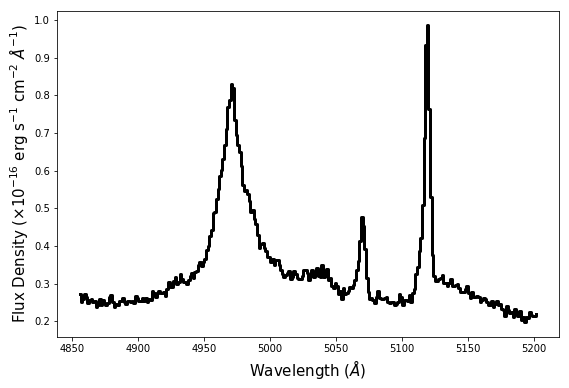

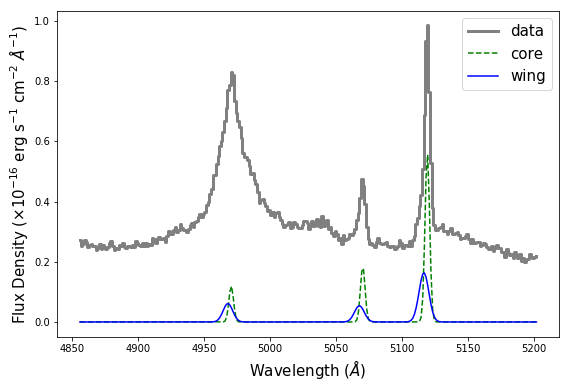

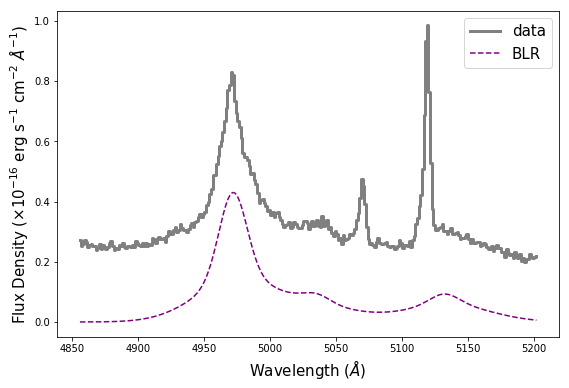

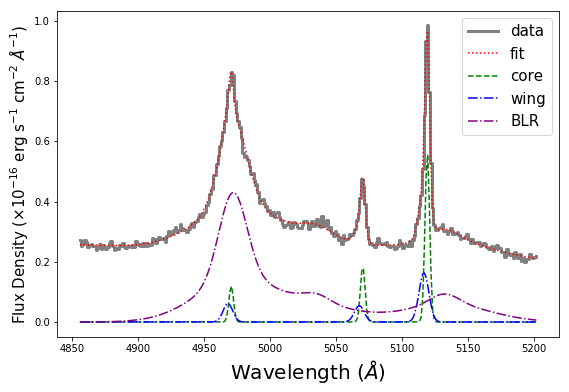

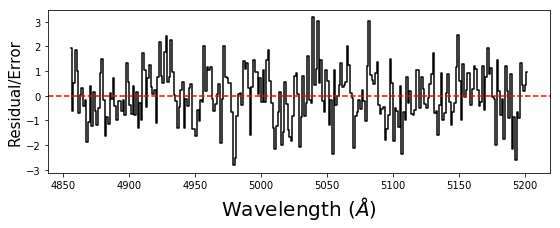

[157, 160]
HE1011-0403
189 222
0.97178704
[1.54790157e-01 1.11520440e+00 1.75309737e+04 1.08971692e+02
 1.01911143e-01 5.30610417e-01 1.72891689e+04 2.57990108e+02
 2.19924473e-01 1.00616215e-02 1.78226653e+04 1.78942436e+03
 7.85047036e-01 1.11273122e-01 1.76829582e+04 8.34440206e+02
 5.46230277e-02 4.61520885e-01] [2.27736424e-02 4.53854119e-02 4.05449242e+00 5.83796068e+00
 2.03235184e-02 3.72181873e-02 2.04569093e+01 1.01402946e+01
 2.50749024e-01 4.71404815e-02 9.36534415e+01 4.28631636e+02
 2.58384645e-01 4.69382514e-02 1.59277392e+02 4.41140988e+02
 1.95378554e-02 1.00942446e-01]


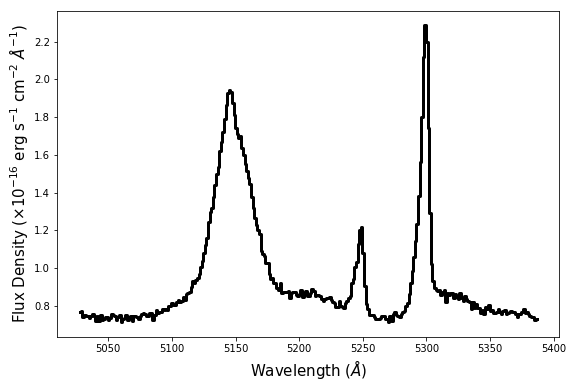

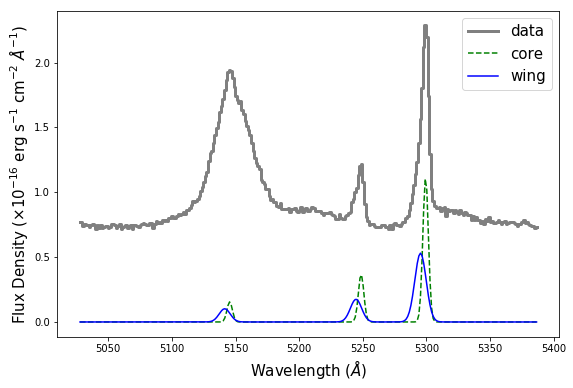

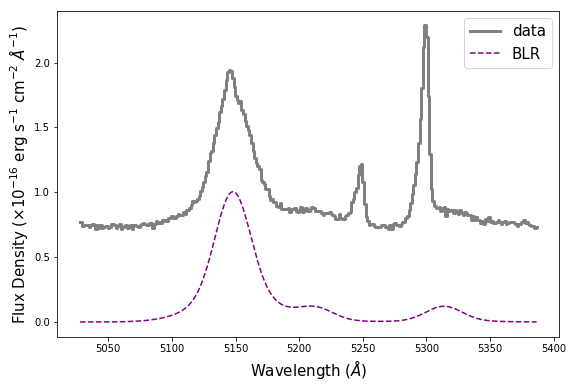

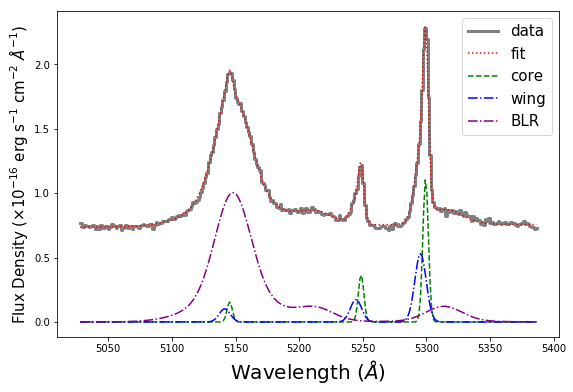

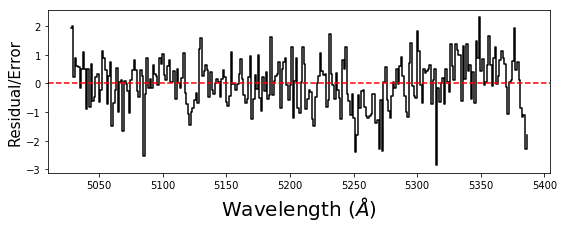

[189, 222]
HE0429-0247
75 82
1.3010414
[ 9.56374033e-01  8.56724987e+00  1.26348653e+04  8.53307481e+01
 -2.37515560e-01  2.09279867e+00  1.25774725e+04  2.16353588e+02
  1.71326993e+00  7.41063470e-02  1.26497143e+04  4.58859785e+02
  1.30666801e+00  1.76949937e-01  1.26773553e+04  1.63215489e+03
 -5.40284619e-01  4.11831262e+00] [4.51305719e-02 8.62715946e-02 4.95687910e-01 1.03736878e+00
 9.38092518e-02 8.59525744e-02 3.05680786e+00 3.05416362e+00
 5.49038076e-02 6.61764839e-03 3.41215984e+00 1.48029919e+01
 2.33747608e-02 7.08443713e-03 6.49231009e+00 1.90163099e+01
 1.42237458e-02 7.24331748e-02]


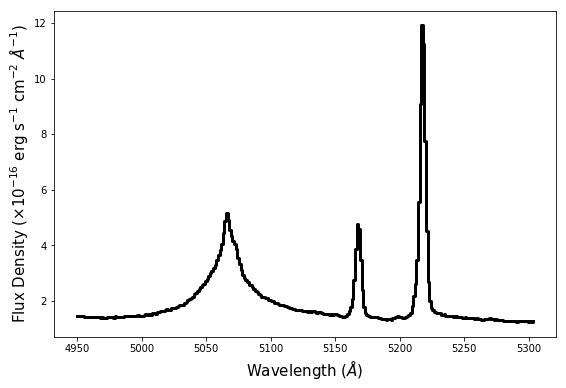

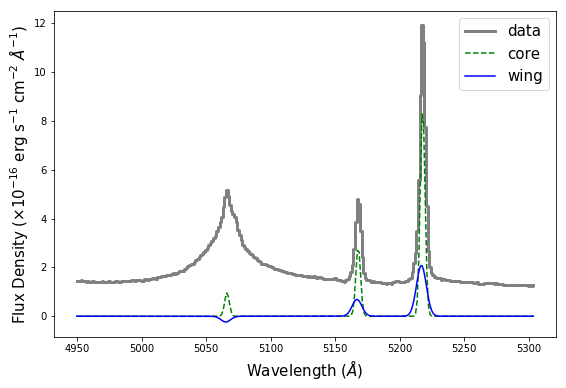

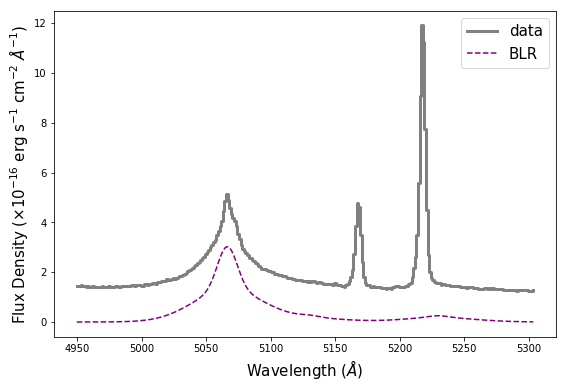

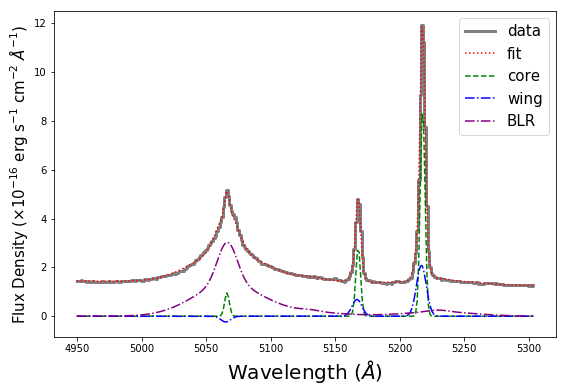

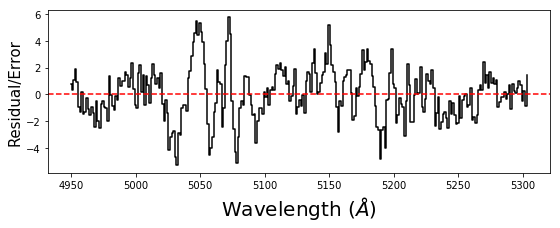

[75, 82]
HE0021-1810
80 75
2.3589199
[ 7.54096432e-02  1.14806144e+00  1.61087455e+04  1.32872108e+02
 -4.83789546e-02  4.43070023e-01  1.59747467e+04  3.49442378e+02
  5.57960862e-02  1.42813263e-01  1.10308650e+04  2.24051969e+03
  0.00000000e+00  0.00000000e+00  1.60560000e+04  1.00000000e+03
 -2.32614926e-01  1.92625977e+00] [1.24669274e-01 1.22301130e+01 1.44543464e+02 2.93348134e+02
 1.06621923e-01 1.21182728e+01 5.93353176e+01 8.67299194e+01
 5.48381005e-02 2.19344039e-02 1.15645571e+03 1.78473281e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.39758084e-01 7.06892230e-01]


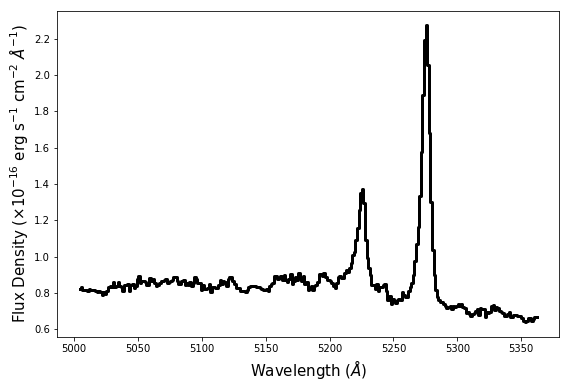

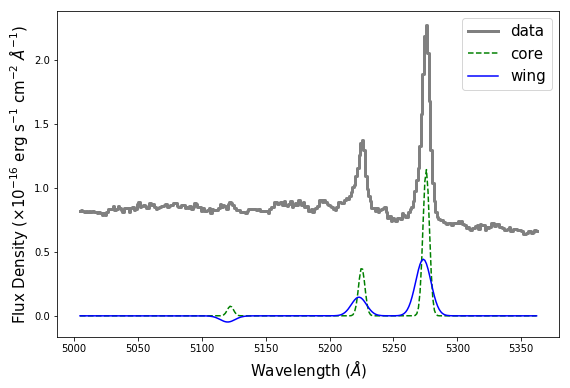

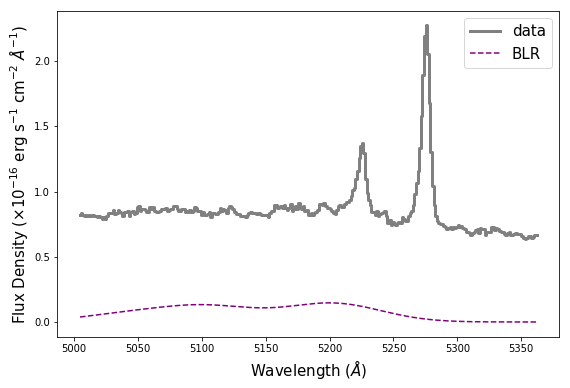

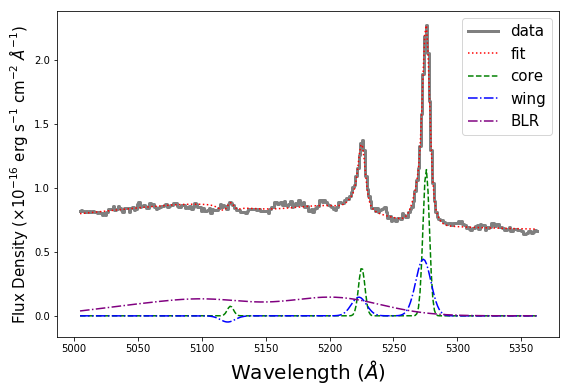

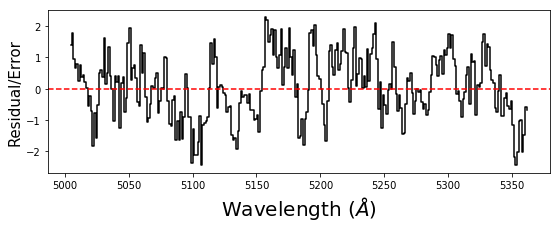

[80, 75]
HE0227-0913
115 87
0.8485682
[ 3.10401824e+00  5.81674981e+00  4.78505562e+03  1.38005833e+02
  2.05743588e+00  6.58690493e-01  4.38406803e+03  3.22995041e+02
  7.06227648e+00  1.76402832e+00  4.91391580e+03  4.01830447e+02
  3.10599053e+00  4.60212575e-01  4.71268206e+03  1.36961781e+03
 -2.97731172e-01  4.74888131e+00] [8.15285175e-02 3.04148258e-02 1.03125102e+00 1.54940196e+00
 5.32547851e-02 2.81497980e-02 1.27159259e+01 5.99110414e+00
 5.34554131e-02 1.22127685e-02 2.74174379e+00 3.50684100e+00
 4.33321739e-02 1.36447198e-02 4.11966491e+00 1.13978969e+01
 1.85437023e-02 9.30799211e-02]


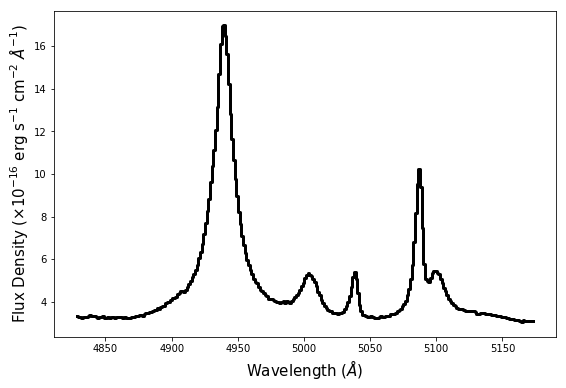

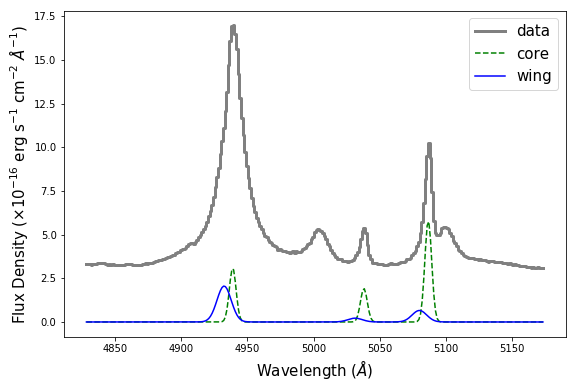

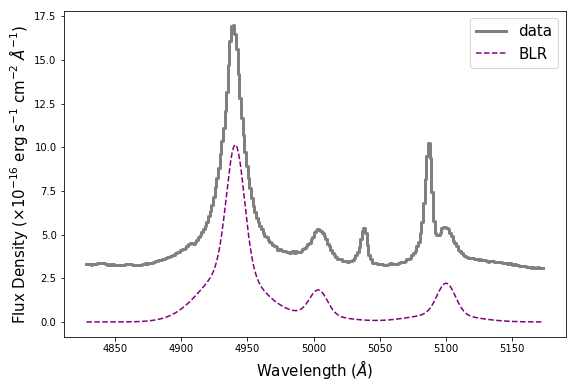

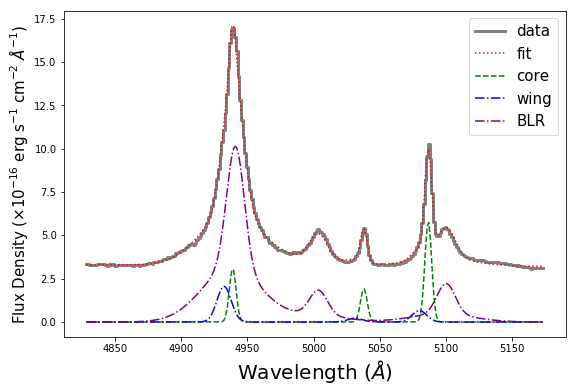

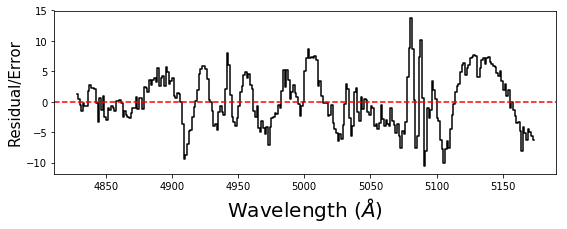

[115, 87]
HE1029-1831
155 218
0.7206983
[ 6.35593375e-01  5.33955611e-01  1.21143610e+04  8.07673493e+01
  1.41331706e-01  1.18281845e+00  1.19885896e+04  2.28331920e+02
  2.66584490e-01  7.06276938e-02  1.20862079e+04  1.73679520e+03
  3.66636867e-01  5.26737854e-02  1.25113899e+04  8.45498708e+02
 -1.28370958e-01  1.13454793e+00] [1.84356813e-02 3.30254697e-02 3.49004352e+00 4.86157180e+00
 3.59706537e-02 2.70752130e-02 3.49396876e+00 2.80107587e+00
 3.93461622e-02 1.18518926e-02 4.44834641e+01 9.05558224e+01
 3.41939564e-02 1.26797231e-02 8.06753472e+01 9.38488760e+01
 9.42335761e-03 4.87138008e-02]


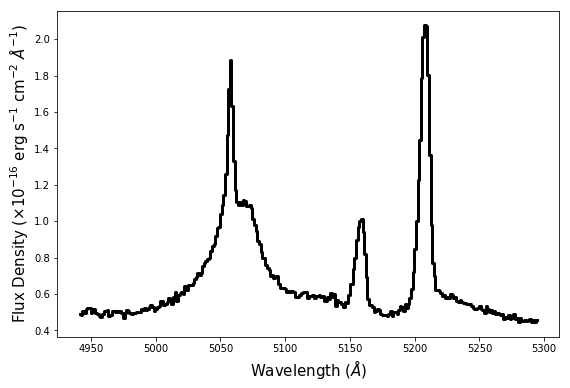

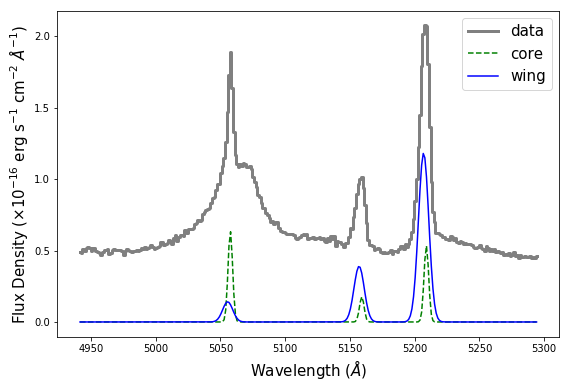

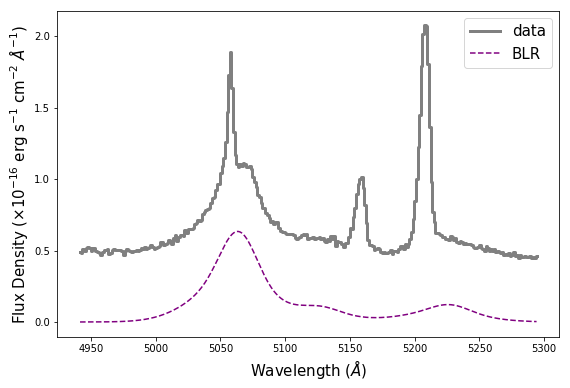

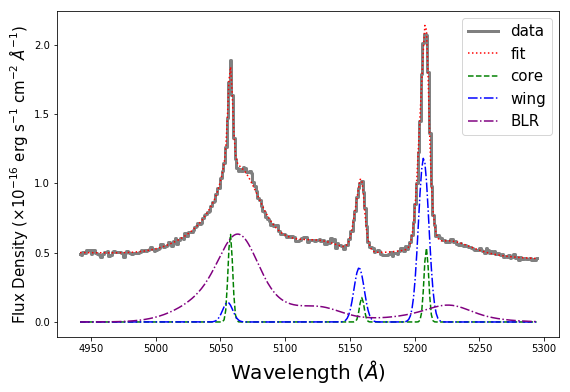

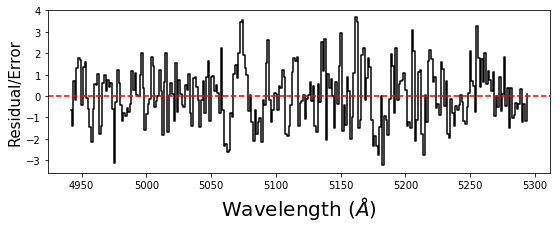

[155, 218]
HE0232-0900
67 51
3.3214335
[ 3.39804634e+00  3.53428668e+01  1.29029244e+04  1.32225297e+02
  1.56306061e-01  1.69155085e+01  1.28193645e+04  2.85839553e+02
  7.62470646e+00  1.18062366e+00  1.29181511e+04  2.19476089e+03
  0.00000000e+00  0.00000000e+00  1.29420000e+04  1.00000000e+03
 -4.11403577e+00  2.91483552e+01] [ 0.43027539  1.25887553  3.17978566  3.8713652   0.3717216   1.35986144
  4.49031732  8.35942696  0.06587565  0.06790273 25.83159024 22.21112728
  0.          0.          0.          0.          0.20047395  1.04013914]


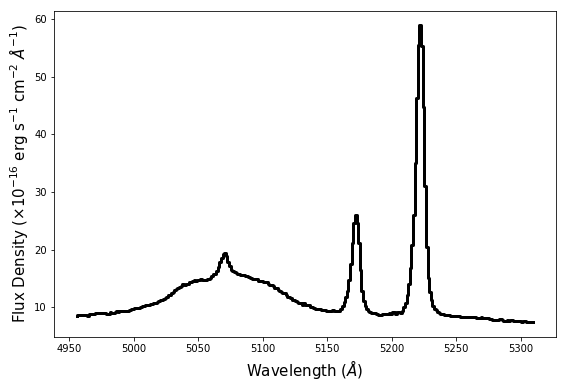

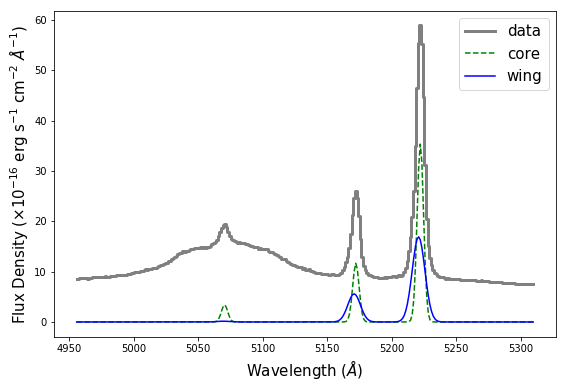

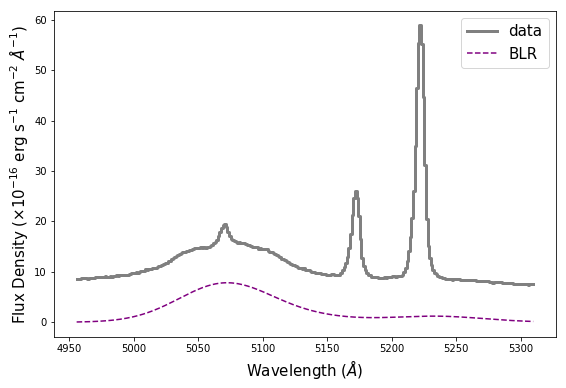

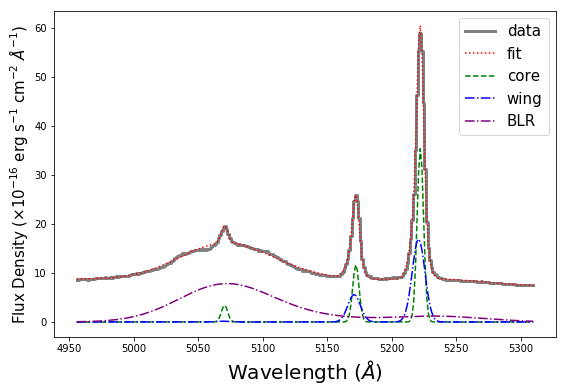

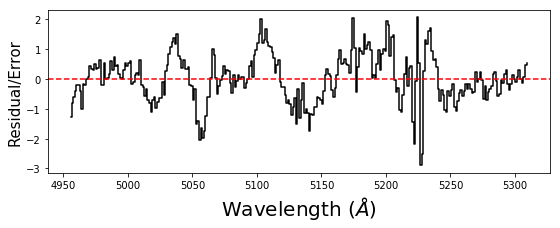

[67, 51]
HE2222-0026
92 90
1.6797135
[ 8.27669693e-02  4.27224741e-01  1.74032638e+04  1.38543591e+02
 -1.73611219e-02  8.32610967e-02  1.71497095e+04  2.90166620e+02
  1.28160488e-01  1.19027609e-02  1.85053847e+04  6.53078092e+02
  1.96766382e-01  2.79175245e-02  1.74591811e+04  1.74685477e+03
 -3.55552100e-03  1.96071392e-01] [1.58095530e-02 3.74240668e-02 1.60788019e+01 1.35326190e+01
 1.58561996e-02 4.34849206e-02 9.32529106e+01 2.64346303e+02
 1.84434146e-02 7.47241134e-03 4.15277960e+01 8.01714914e+01
 1.95014051e-02 9.79438860e-03 1.28789483e+02 4.97805298e+01
 7.54529422e-03 3.92386271e-02]


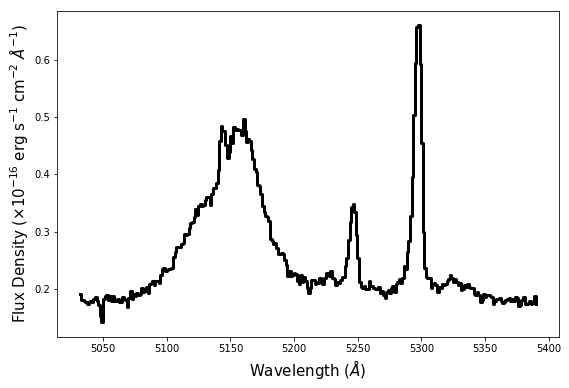

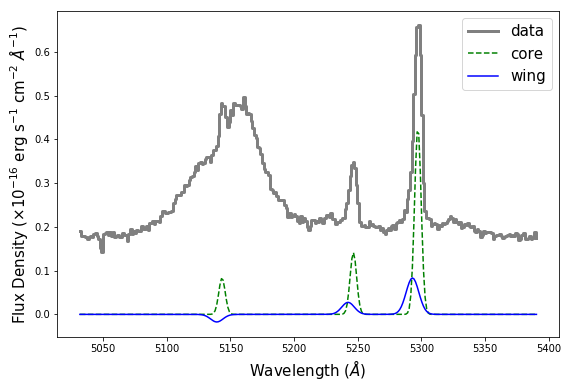

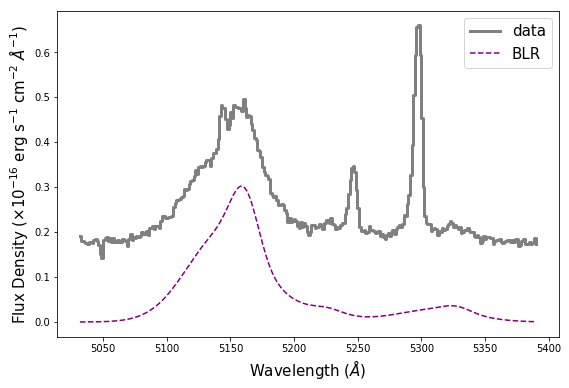

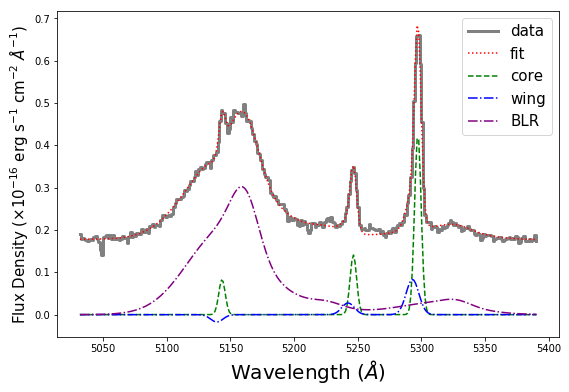

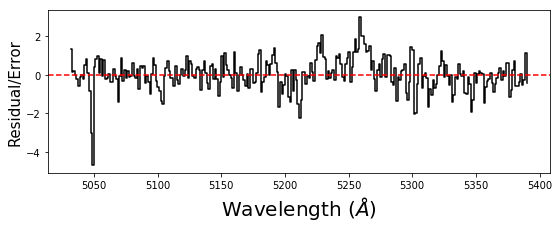

[92, 90]
HE2302-0857
139 160
2.577658
[ 7.28172656e-01  8.24277610e+00  1.41566009e+04  2.01461134e+02
  1.51310650e-01  1.26680701e+00  1.43868414e+04  5.99746629e+02
  1.25717997e+00  2.21691884e-01  1.39155489e+04  2.48938590e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.71262830e-01  4.06197608e+00] [6.92500846e-02 1.39673537e-01 3.78015854e+00 3.67264787e+00
 6.22428452e-02 1.08688343e-01 2.37532978e+01 1.25065665e+02
 2.89030816e-02 4.03627890e-02 7.57879096e+01 5.42725735e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.13222423e-02 4.19054370e-01]


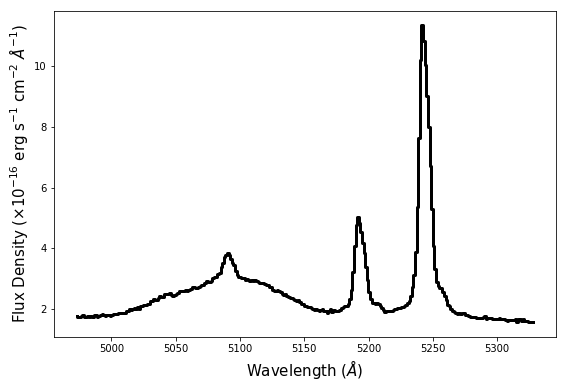

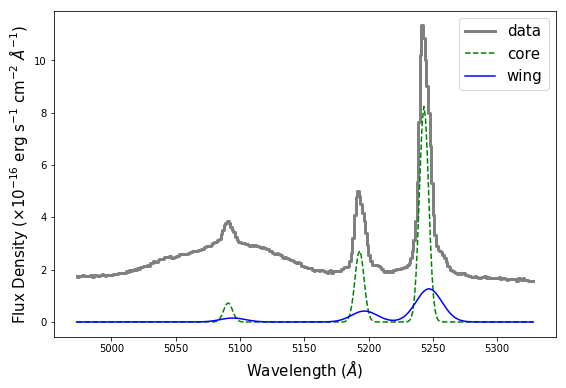

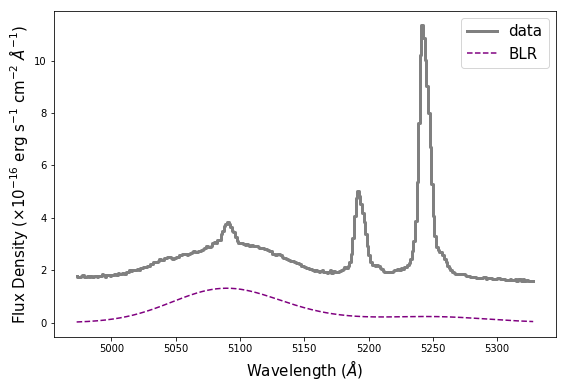

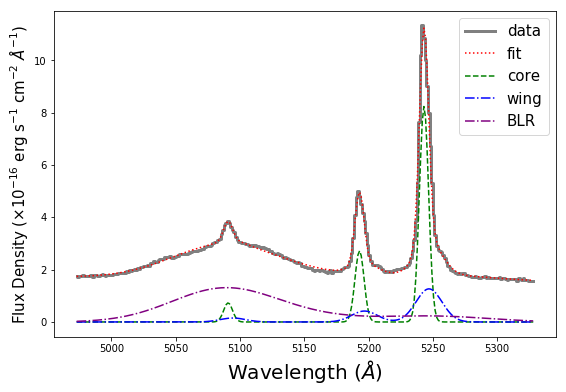

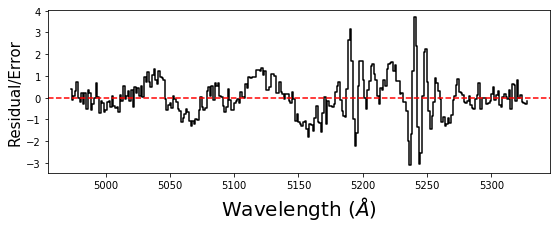

[139, 160]
HE0021-1819
117 153
1.7755454
[ 1.30765141e-01  1.64813399e+00  1.59588170e+04  7.18814056e+01
  4.86691083e-02  3.07470629e-01  1.57993409e+04  2.95912927e+02
  5.70353873e-02  7.45348590e-03  1.59494886e+04  1.51717570e+03
  0.00000000e+00  0.00000000e+00  1.59590000e+04  1.00000000e+03
 -4.12796498e-02  2.81573262e-01] [7.91953938e-03 2.40175473e-02 1.07378035e+00 1.61999345e+00
 4.63190439e-03 8.80069205e-03 5.46200727e+00 4.50459628e+00
 1.76095490e-03 1.06720092e-03 4.23969388e+01 4.29594786e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.78097376e-03 1.43655350e-02]


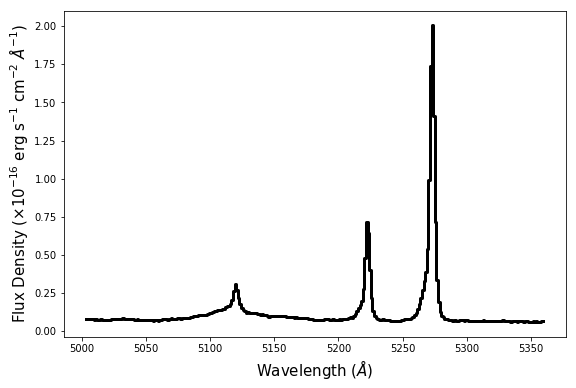

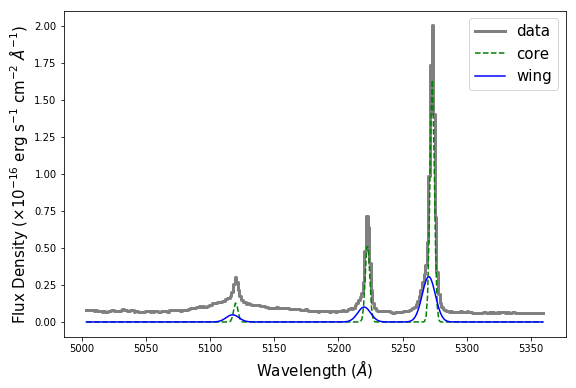

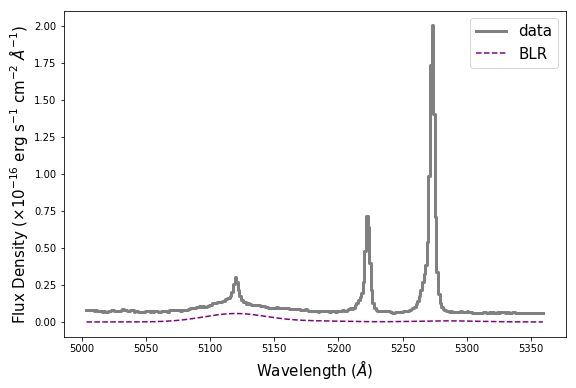

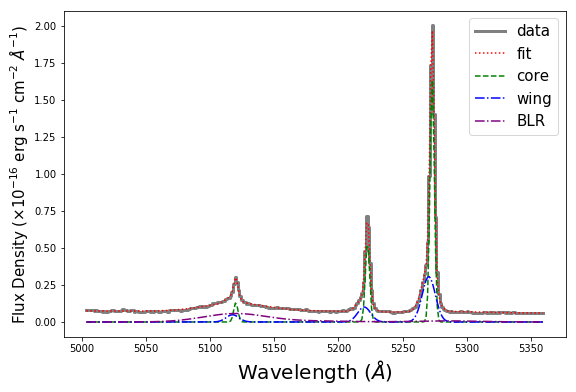

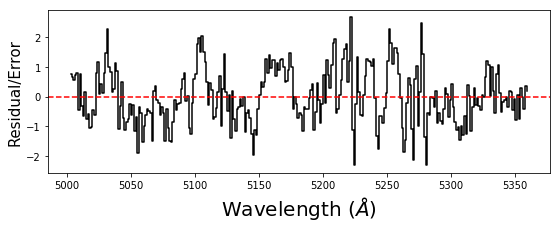

[117, 153]
HE2128-0221
156 211
0.9814571
[ 7.23922142e-02  1.17198784e+00  1.57580980e+04  4.81666294e+01
  1.75648835e-01  5.44949476e-01  1.57240936e+04  1.26269558e+02
  2.19711724e-01  2.65736155e-02  1.58176221e+04  8.82964988e+02
  0.00000000e+00  0.00000000e+00  1.57440000e+04  1.00000000e+03
 -2.17403523e-02  2.85130435e-01] [8.84616660e-02 2.44974890e-01 2.71715302e+00 1.18167562e+01
 7.28814827e-02 2.17695621e-01 9.40132498e+01 3.73993563e+01
 5.54328674e-03 1.39906459e-03 1.01923993e+01 1.83827272e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.88494849e-03 1.49225420e-02]


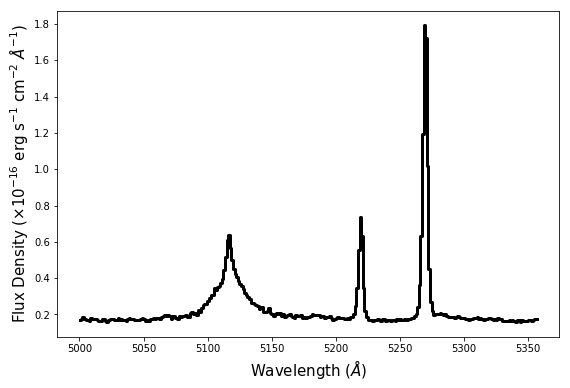

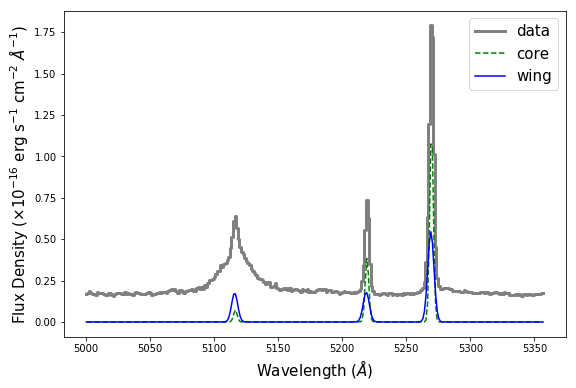

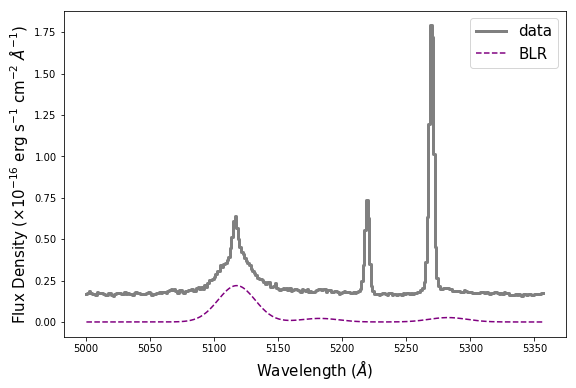

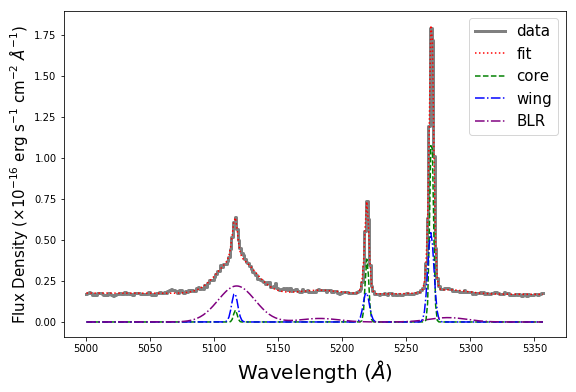

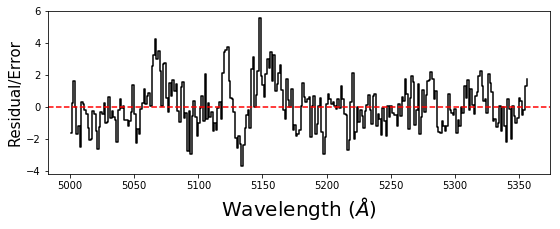

[156, 211]
HE0853+0102
162 116
1.4073384
[ 9.90116468e-02  9.47334855e-01  1.57078646e+04  1.01945256e+02
  2.15243855e-02  3.00553155e-01  1.56749496e+04  3.13369061e+02
  1.75278032e-01  2.76834016e-02  1.59019144e+04  1.64438181e+03
  3.75414964e-02  3.07960990e-05  1.72605798e+04  7.88553863e+02
 -1.46285005e-02  1.63145278e-01] [1.07428367e-02 2.61708528e-02 1.76502144e+00 4.37442002e+00
 1.05130365e-02 2.78672064e-02 5.08624360e+00 1.43663843e+01
 2.02450704e-02 3.60692317e-03 2.56945363e+02 9.36802107e+01
 2.58241962e-02 4.63593524e-03 1.92603155e+02 2.15089639e+02
 4.37336688e-03 2.25514016e-02]


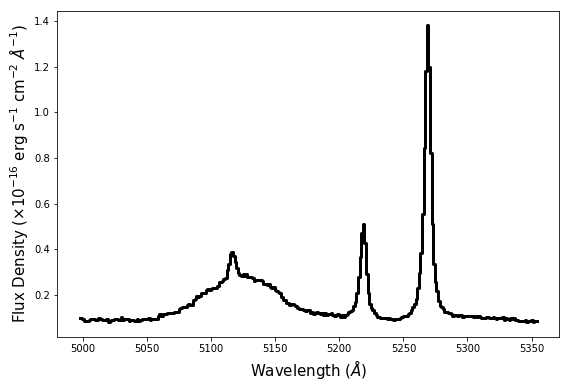

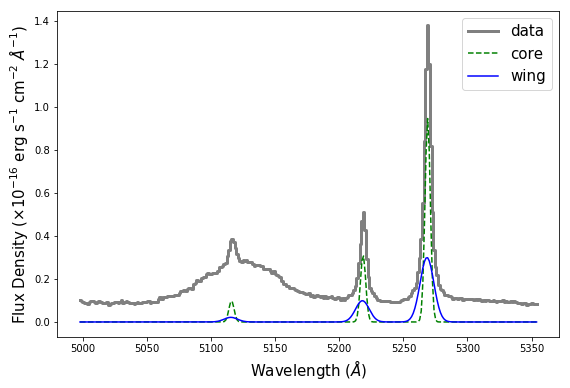

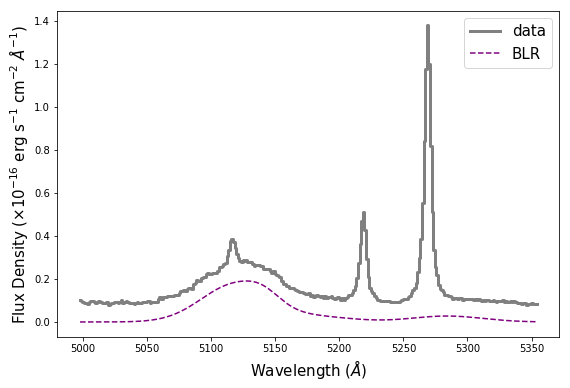

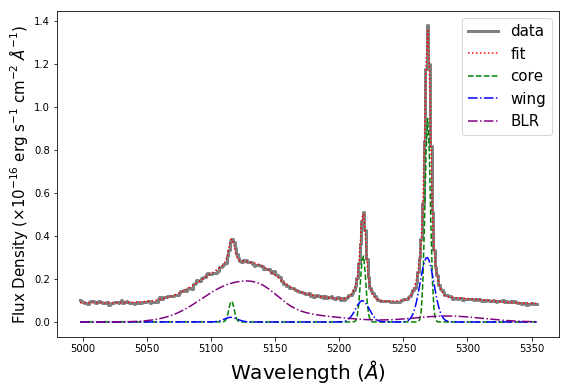

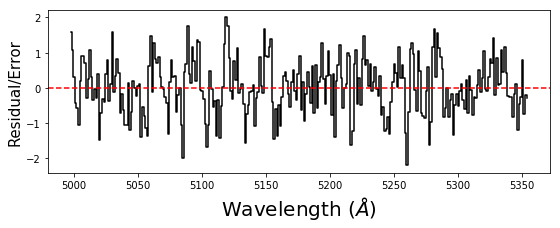

[162, 116]
HE1237-0504
228 224
0.9456109
[ 7.64256833e-01  1.13497451e+01  2.48186413e+03  1.11830441e+02
  8.09315802e-01  1.86204728e+00  2.28598473e+03  3.24168874e+02
  2.29403759e+00  6.05010674e-01  2.48925528e+03  1.65723682e+03
  0.00000000e+00  0.00000000e+00  2.70000000e+03  1.00000000e+03
 -2.20738423e-01  1.74729394e+00] [2.81146224e-02 3.66131475e-02 4.13280593e-01 4.53248626e-01
 1.98690977e-02 2.16712209e-02 2.14819116e+00 2.09565053e+00
 6.05717303e-03 2.38432167e-03 2.60170861e+00 3.57724358e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.78211895e-03 2.87649130e-02]


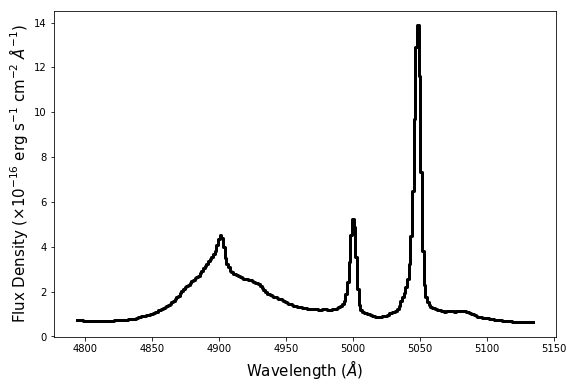

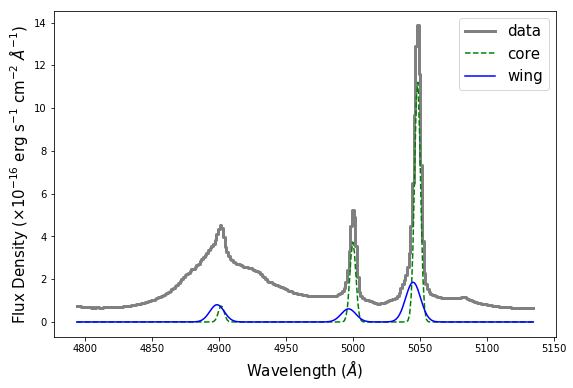

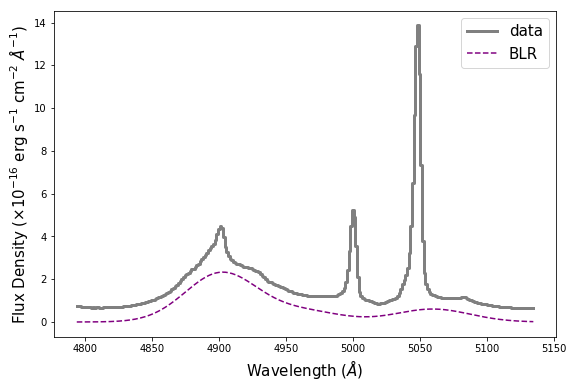

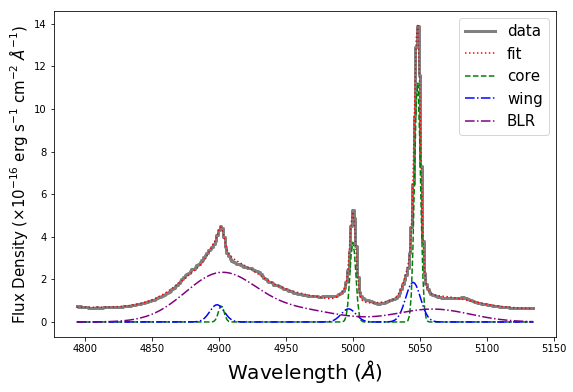

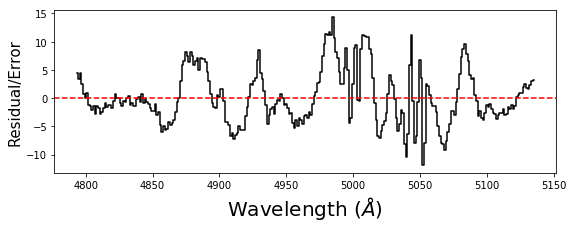

[228, 224]
HE1107-0813
161 158
1.1399627
[ 3.99486547e-02  2.61496716e-01  1.75441648e+04  8.62933367e+01
  2.16079135e-01  1.28166775e-01  1.73852413e+04  4.85119513e+02
  8.68341130e-01  3.46444173e-01  1.75621524e+04  1.00209675e+03
  8.66721689e-01  1.29457074e-01  1.68106602e+04  1.91890818e+03
 -9.92976146e-01  8.13740005e+00] [3.50700995e-02 2.31898022e-02 9.00073113e+00 1.96221415e+01
 2.80636453e-02 1.64703317e-02 4.19877134e+01 4.46105266e+01
 5.69031494e-02 1.29268477e-02 1.82978939e+01 3.93890010e+01
 5.35235388e-02 1.63902597e-02 6.11036771e+01 3.41345966e+01
 1.98856066e-02 1.04069777e-01]


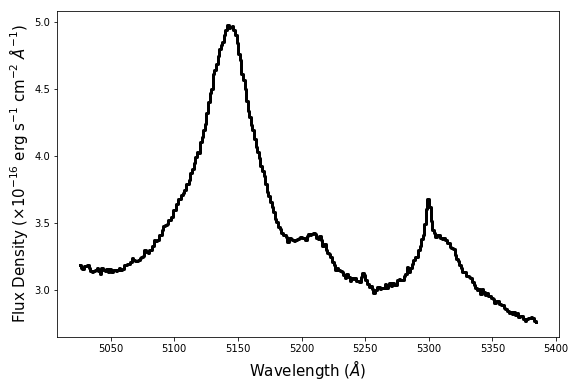

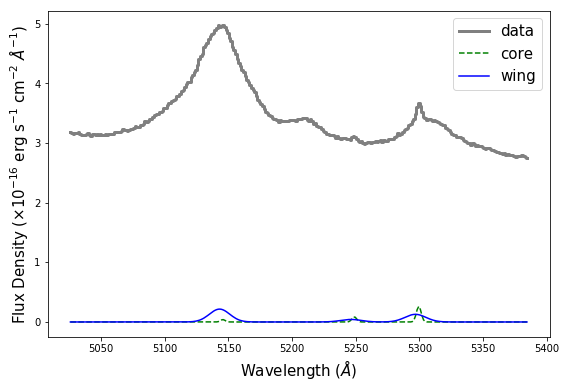

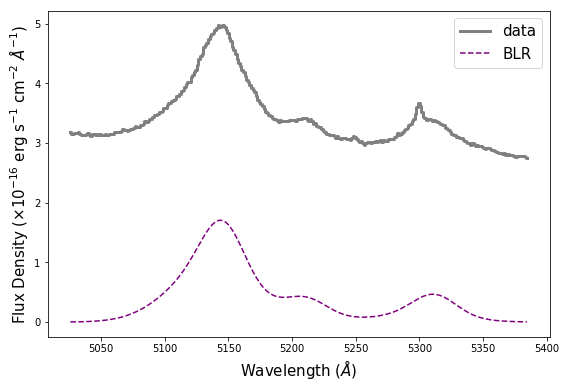

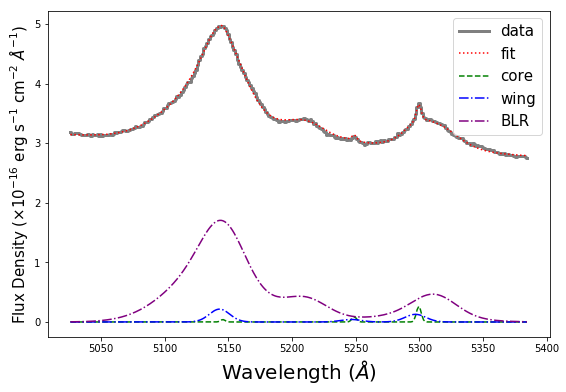

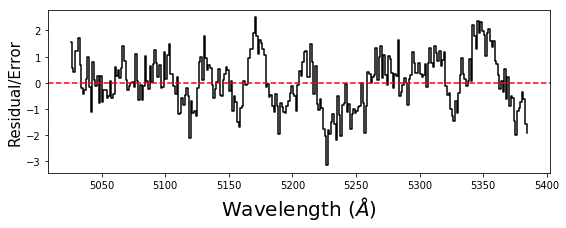

[161, 158]
HE0114-0015
167 162
1.0210758
[ 2.15749600e-01  4.65999801e-01  1.36738060e+04  1.07954449e+02
  2.81642501e-02  6.98977665e-02  1.35754786e+04  3.28966931e+02
  1.09138615e-01  3.52450975e-02  1.36811048e+04  1.22817439e+03
  0.00000000e+00  0.00000000e+00  1.36800000e+04  1.00000000e+03
 -2.00475884e-02  1.94913488e-01] [2.93117238e-02 3.54236977e-02 7.68814537e+00 5.72354331e+00
 2.74028163e-02 3.62255032e-02 6.06128936e+01 5.04434154e+01
 3.25865944e-03 1.41725883e-03 1.83260808e+01 2.57451089e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.37081141e-03 1.71941496e-02]


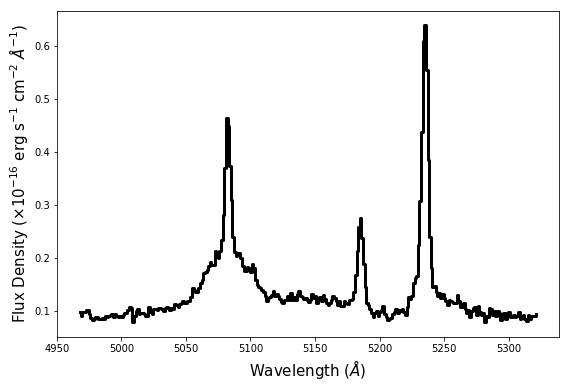

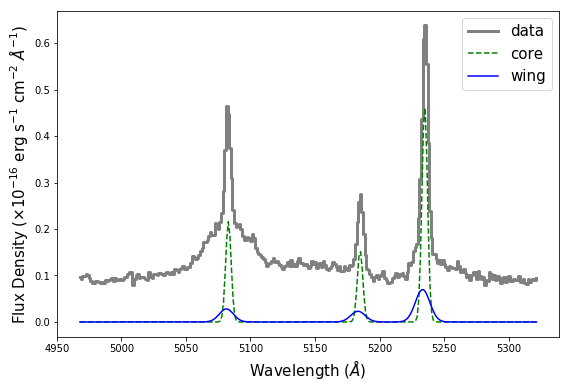

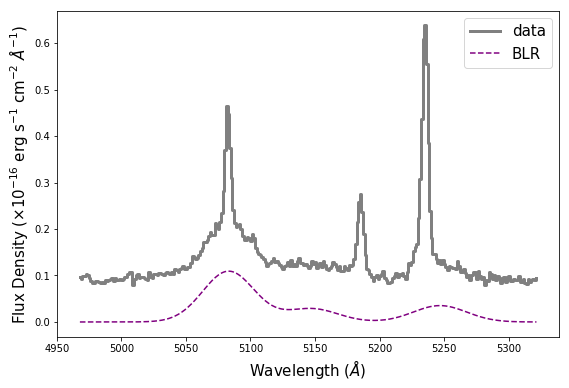

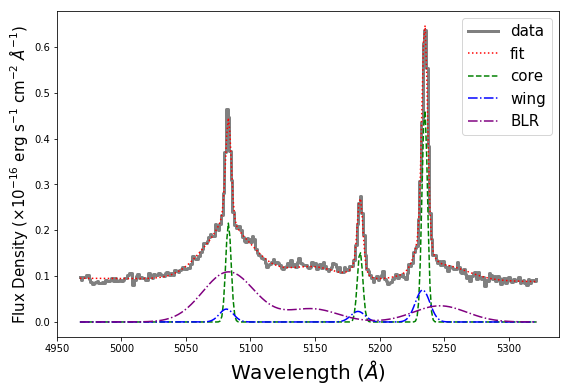

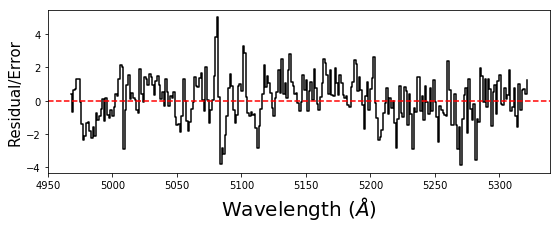

[167, 162]
HE2211-3903
156 164
0.70222497
[3.87004171e-01 2.78020309e+00 1.18531455e+04 7.34006284e+01
 4.89870735e-02 1.13429072e-01 1.15141552e+04 9.52160970e+01
 3.56540111e-01 5.23539911e-02 1.16278549e+04 2.57641244e+03
 0.00000000e+00 0.00000000e+00 1.19140000e+04 1.00000000e+02
 1.10107209e-01 2.84481467e-01] [1.77948189e-02 3.50411183e-02 6.93736681e-01 2.12995203e+00
 8.32354989e-03 1.92179777e-02 6.01743214e+01 4.25665950e+01
 2.07659545e-03 2.45369848e-03 1.93976911e+01 1.90943036e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.91641631e-03 4.57649183e-02]


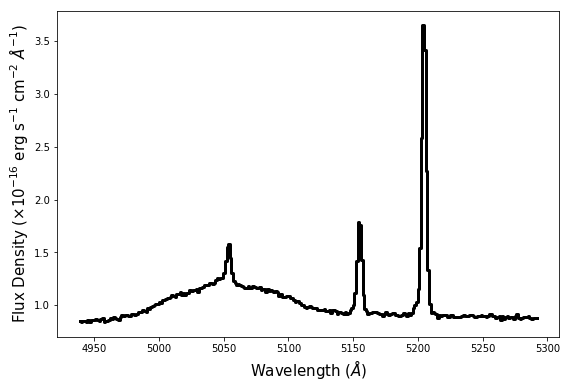

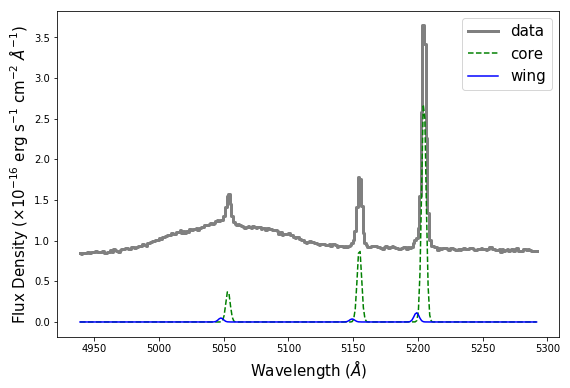

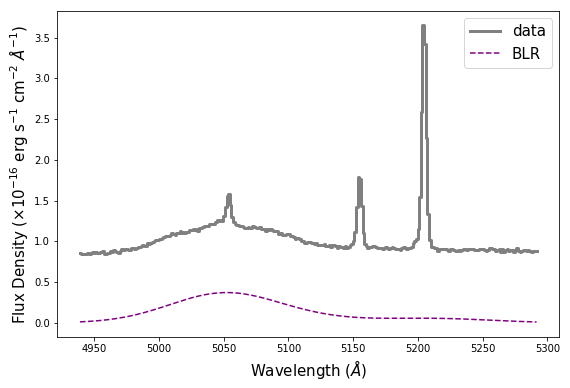

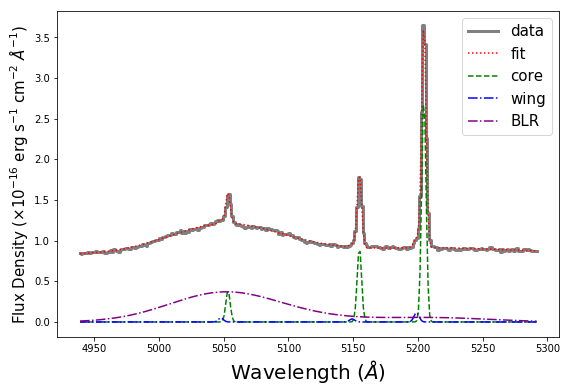

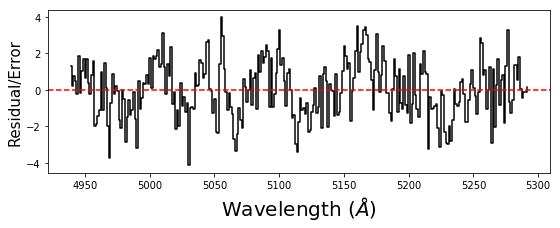

[156, 164]
HE0351+0240
75 93
1.3546728
[ 2.19466531e+00  3.69644980e+01  1.06360062e+04  6.75604414e+01
  1.05996465e+00  1.58758296e+00  1.06199728e+04  2.69329028e+02
  1.51213945e+00  9.18386870e-02  1.15845444e+04  3.17244576e+02
  3.48908646e+00  3.52565574e-01  1.06518075e+04  1.32866234e+03
 -2.58355471e-01  3.15725546e+00] [6.60447546e-02 1.82935914e-01 2.60772783e-01 7.26695420e-01
 6.90633210e-02 1.66200724e-01 4.98596228e+00 1.46344357e+01
 5.10815312e-02 1.42370900e-02 7.94218986e+00 8.91561863e+00
 5.00180404e-02 1.08768865e-02 8.44032889e+00 1.19724672e+01
 2.44032779e-02 1.24446992e-01]


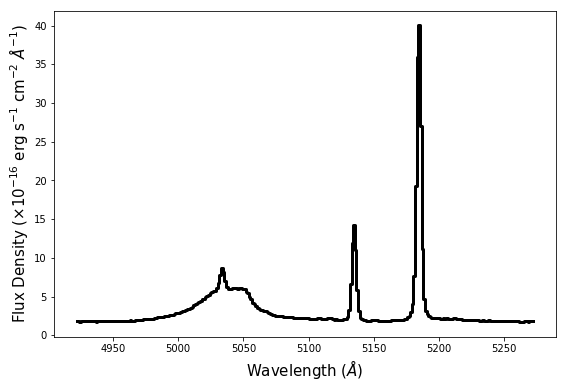

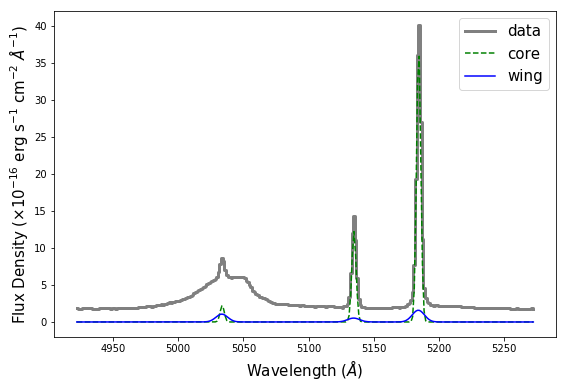

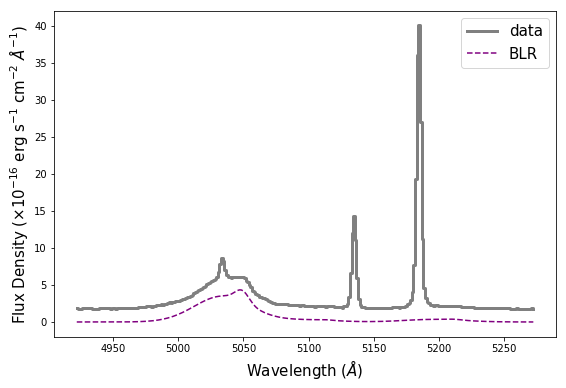

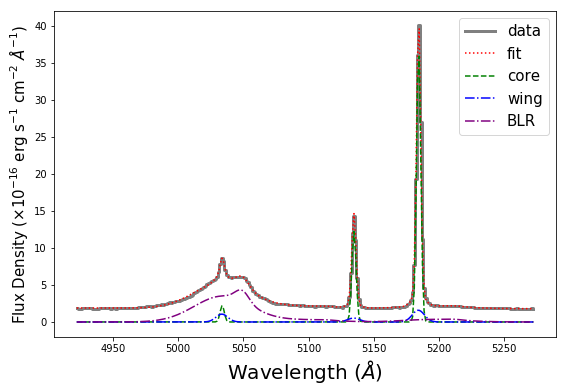

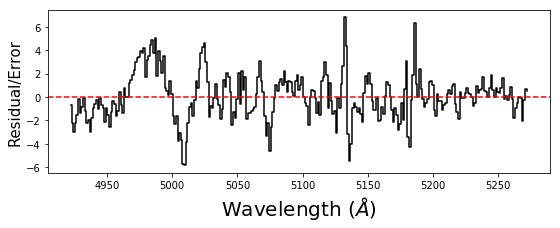

[75, 93]
HE0040-1105
190 151
0.858292
[1.94296500e-01 2.59844699e+00 1.25636203e+04 7.37052847e+01
 9.99724196e-02 5.15947097e-01 1.24409090e+04 2.43754643e+02
 3.31843752e-01 3.69859813e-02 1.29164535e+04 1.19213090e+03
 0.00000000e+00 0.00000000e+00 1.25070000e+04 1.00000000e+03
 3.61733715e-02 1.38161789e-02] [1.06290048e-02 2.29714440e-02 7.97996028e-01 1.31156446e+00
 7.81524381e-03 1.74803202e-02 4.27024786e+00 3.55415850e+00
 2.16416270e-03 1.16373826e-03 7.10187991e+00 7.26835073e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.40923412e-03 1.74056031e-02]


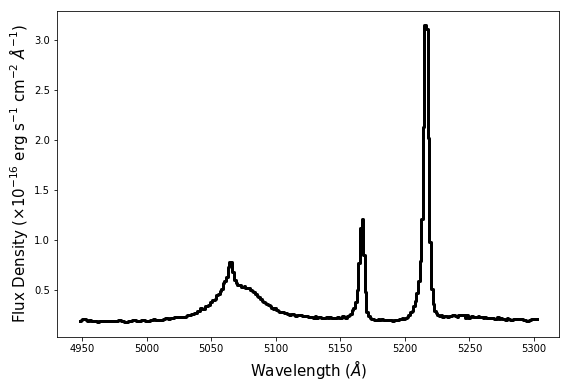

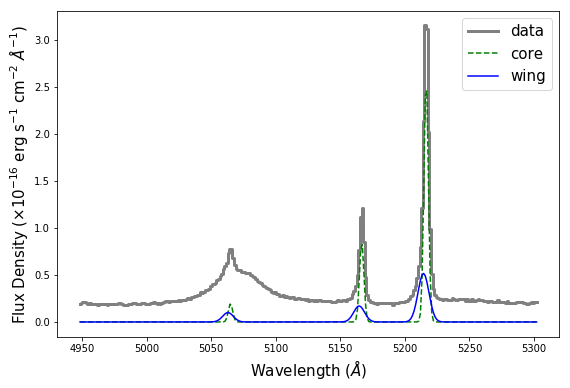

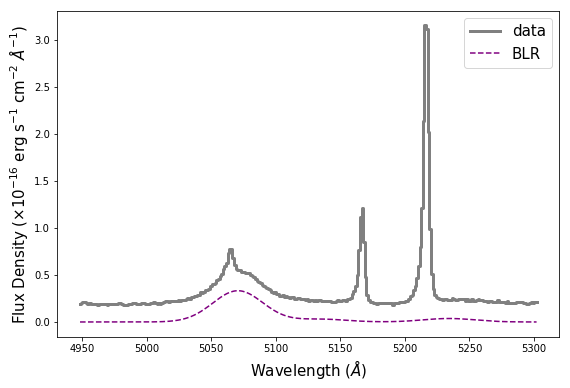

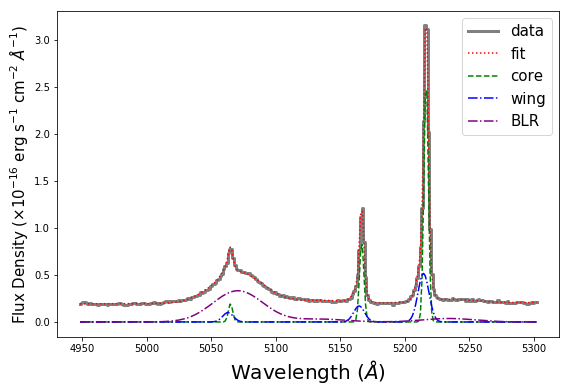

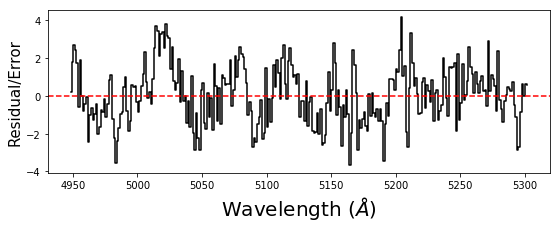

[190, 151]
HE0253-1641
96 41
1.5293405
[1.75324353e+00 1.86856081e+01 9.53707131e+03 1.09105597e+02
 1.10634601e+00 6.71522364e+00 9.28299468e+03 3.70338119e+02
 1.71175371e+00 3.83184137e-01 9.23623523e+03 1.76800377e+03
 2.81441971e+00 7.81636116e-01 9.75142087e+03 5.48888772e+02
 5.94269973e-02 4.22727391e+00] [1.17290055e-01 1.51732294e-01 1.42568109e+00 1.89703872e+00
 1.27199987e-01 1.41024821e-01 6.63891386e+00 5.75800187e+00
 4.00962868e-02 4.84779262e-02 4.54556154e+01 3.17307403e+01
 8.44028132e-02 4.44400569e-02 1.58477534e+01 1.30509122e+01
 6.26658382e-02 3.16841845e-01]


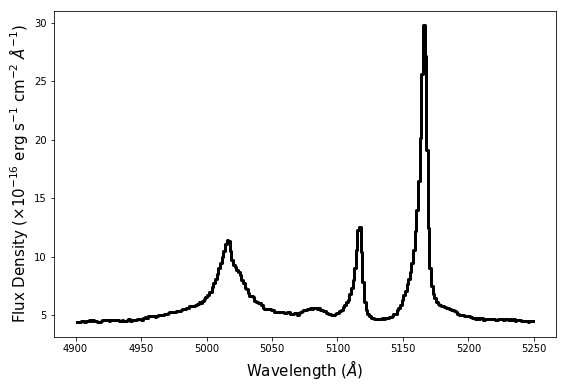

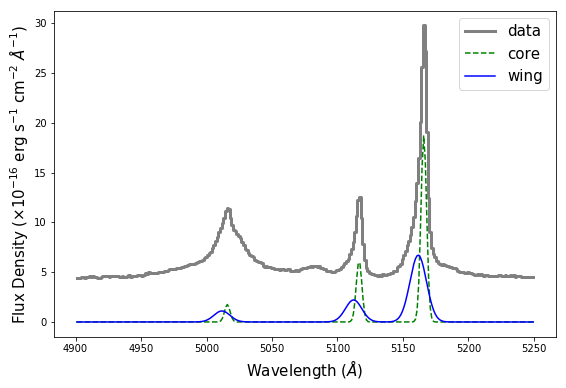

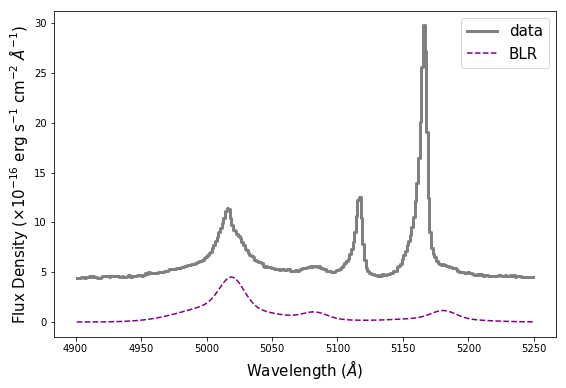

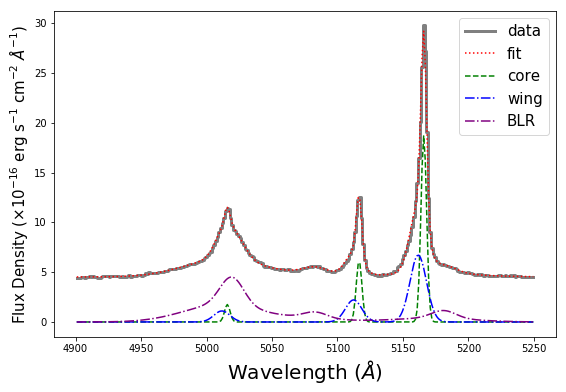

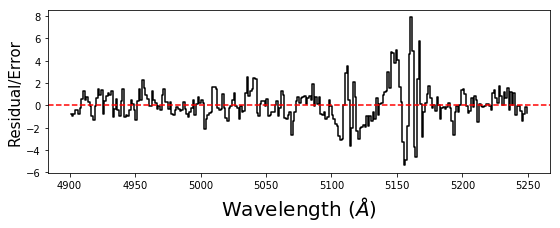

[96, 41]
HE1126-0407
76 80
4.7285314
[ 9.79627098e-01  1.34338474e+01  1.80272035e+04  1.18994923e+02
  2.50010194e+00  2.85641357e+00  1.77595826e+04  3.51918236e+02
  9.81869169e+00  1.29483328e+00  1.80827535e+04  7.11233339e+02
  7.44811041e+00  1.77786381e+00  1.79654920e+04  1.76366477e+03
 -8.75409282e-01  1.42675154e+01] [ 0.32361136  1.12082    28.93800094 23.74779781  0.37530817  1.09264759
 39.71947417 30.89921262  0.38429284  0.09623272 15.17704695 27.07516976
  0.37415091  0.10706928 21.70756339 40.55494353  0.14306714  0.7480645 ]


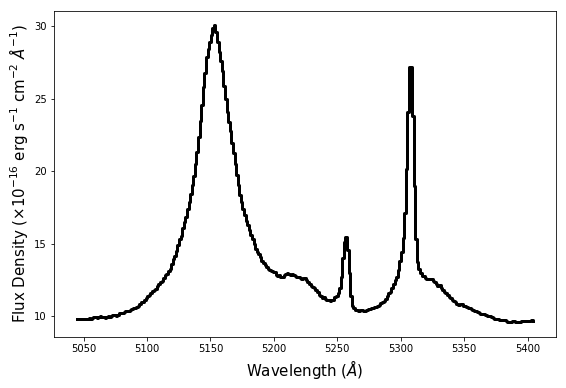

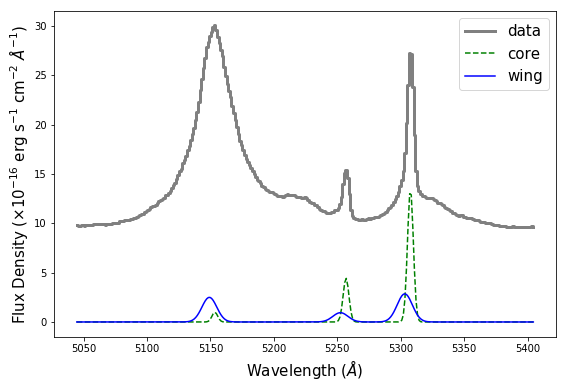

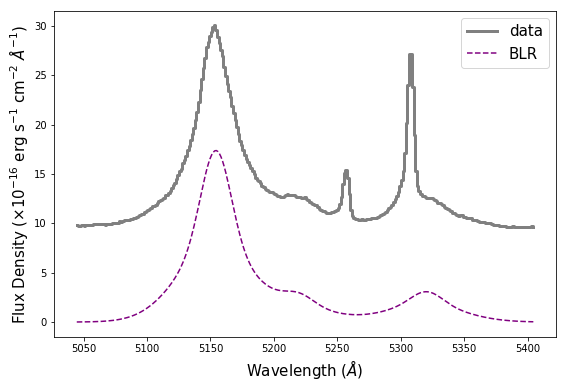

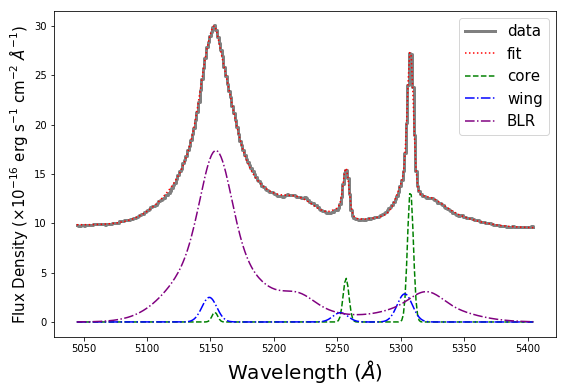

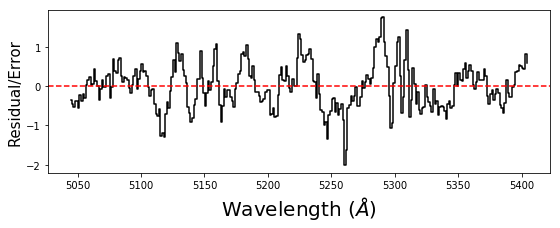

[76, 80]
HE0119-0118
113 80
2.4159665
[ 1.42698239e+00  1.28325948e+01  1.63324299e+04  1.11048907e+02
  4.35191906e-01  8.72550662e+00  1.61239645e+04  2.46339751e+02
  1.52569488e+00  6.53393458e-02  1.65578084e+04  9.88319004e+02
  1.42422110e+00  4.09905344e-01  1.63297667e+04  2.49418746e+03
 -1.58717195e+00  1.06384011e+01] [9.10874845e-02 3.19826826e-01 2.82095130e+00 3.49076951e+00
 7.97738594e-02 3.16924483e-01 6.62594771e+00 2.92996018e+00
 7.68008275e-02 3.04929687e-02 3.22115719e+01 5.69463163e+01
 9.09077781e-02 3.01968759e-02 6.57736854e+01 8.19342733e+01
 8.47871653e-02 4.46233530e-01]


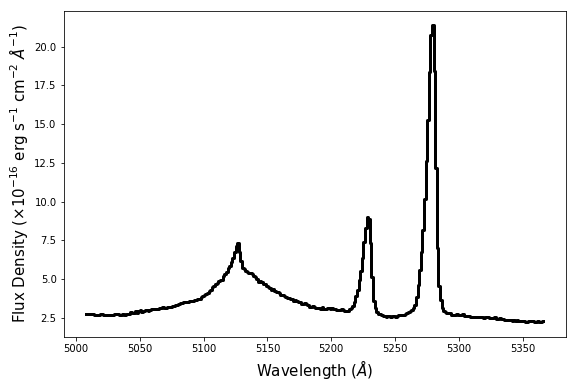

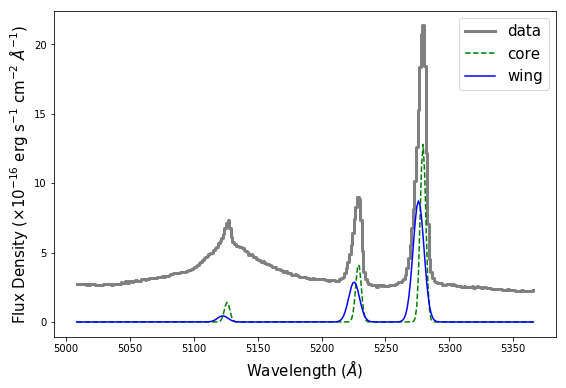

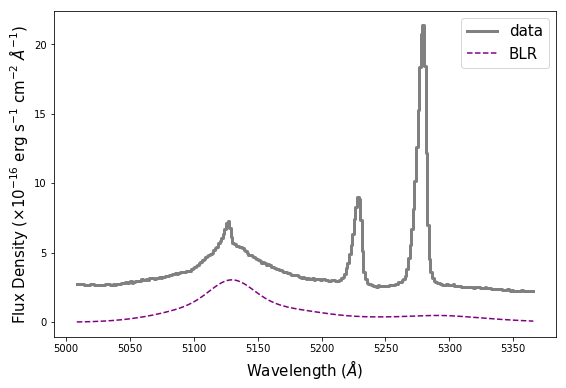

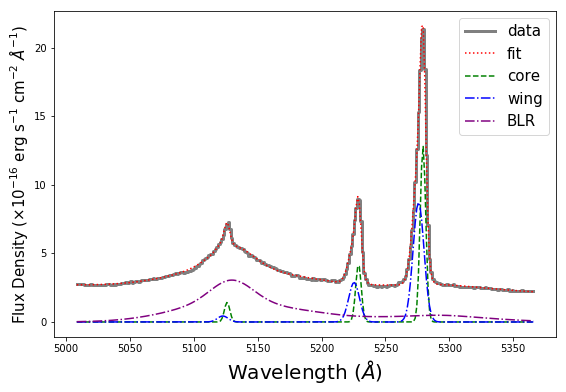

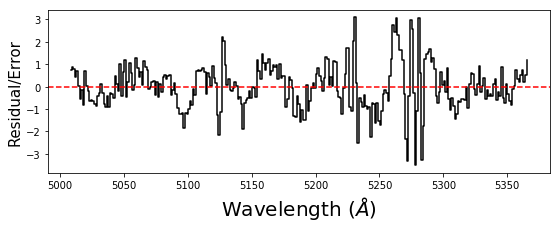

[113, 80]
HE1248-1356
161 162
1.2868639
[ 3.28094618e-01  3.79265568e+00  4.28498120e+03  5.47010347e+01
  1.02553821e-01  4.65227469e-01  4.26232317e+03  2.18648101e+02
  1.51891650e-01  3.77666371e-02  4.30781380e+03  1.49513072e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.61616347e-02 -5.68339173e-02] [8.12840323e-02 1.21803500e+00 6.98179532e+00 9.02183387e+01
 7.84446701e-02 1.22364241e+00 9.50923997e+00 6.23481972e+01
 4.81086205e-03 1.95341330e-03 3.59449784e+01 6.12517149e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.39671600e-03 3.25312845e-02]


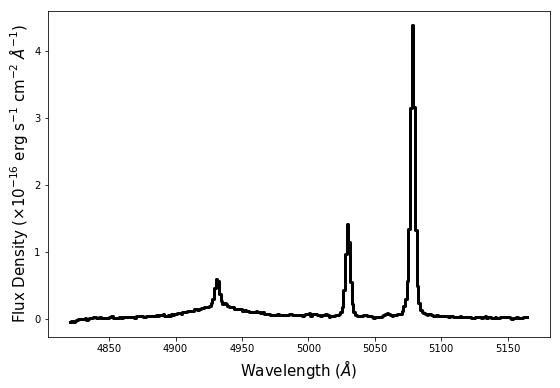

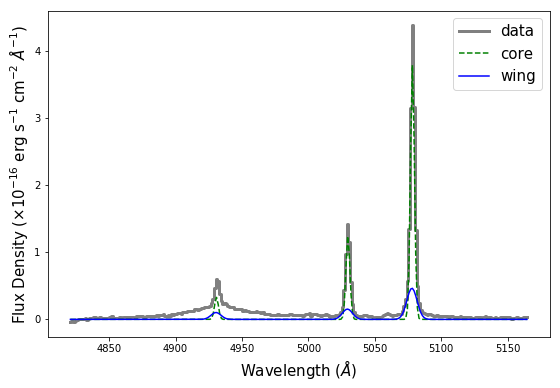

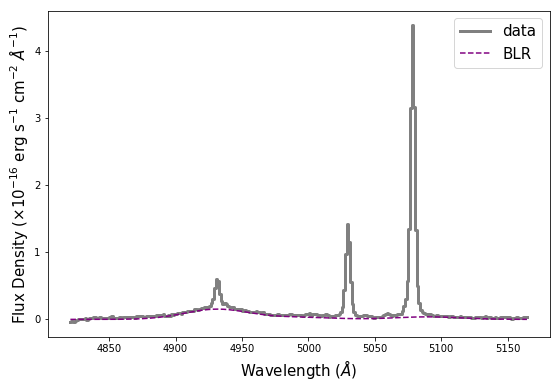

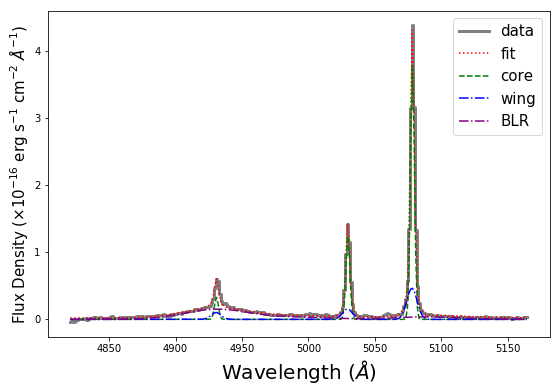

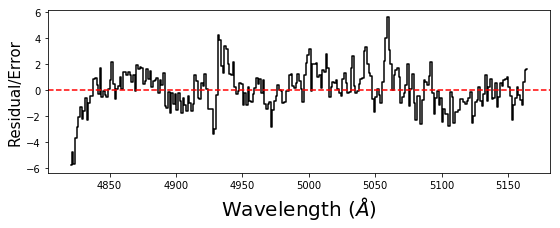

[161, 162]
HE0108-4743
79 79
1.8716198
[1.70700941e+00 4.86596441e+00 7.15752927e+03 5.44075928e+01
 1.56850977e-01 1.77943442e+00 7.08135365e+03 1.31740063e+02
 3.01883999e-01 7.16942277e-02 7.02154825e+03 1.48557346e+03
 1.23839725e+00 2.26312250e-01 7.17635838e+03 4.71405938e+02
 1.26427239e-01 1.59399739e-01] [1.39801201e-01 5.80767938e-01 5.24061019e+00 8.67479730e+00
 1.68080886e-01 6.05168211e-01 2.07257470e+01 1.66768874e+01
 7.64849765e-02 2.32279890e-02 1.33627429e+02 2.34877451e+02
 6.19184527e-02 2.39026328e-02 1.56695625e+01 3.98442012e+01
 3.69693402e-02 1.89115944e-01]


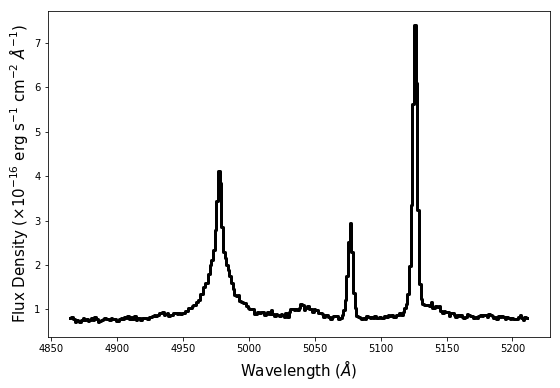

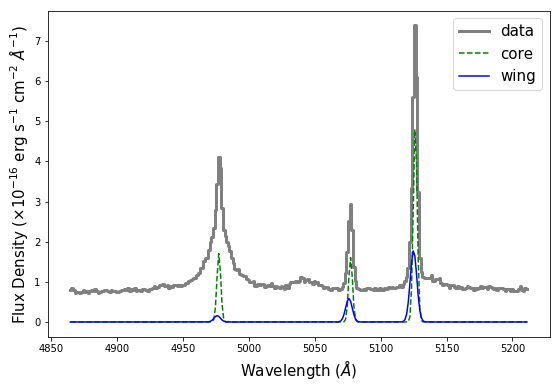

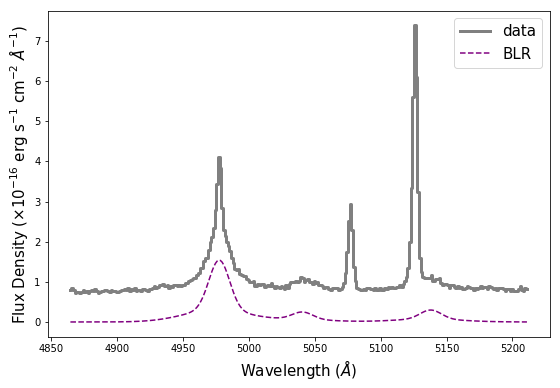

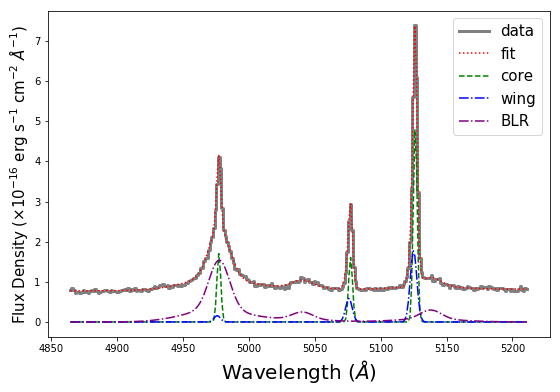

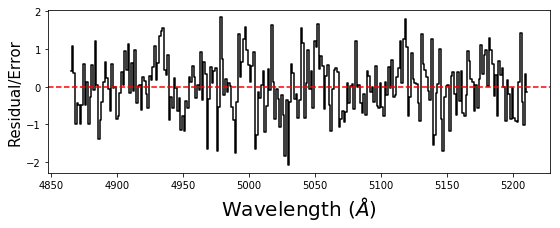

[79, 79]
HE1353-1917
199 195
1.0092027
[ 4.94982919e-02  7.80793589e-01  1.04793050e+04  7.87751475e+01
  1.67568979e-02  1.03302493e-01  1.03269927e+04  4.48512515e+02
  7.39075929e-02  1.00172964e-02  8.08264688e+03  1.41024928e+03
  1.19744194e-01  1.59058493e-02  1.13968531e+04  2.26577304e+03
 -1.22900106e-01  1.09492827e+00] [1.07341070e-02 1.24788368e-02 1.69958995e+00 3.41974435e+00
 1.09177385e-02 7.92672791e-03 2.23456874e+01 2.41850961e+01
 3.46552348e-02 6.21646159e-03 2.96820311e+02 4.64173381e+02
 1.87724635e-02 5.20209135e-03 7.14253229e+02 4.02095869e+02
 2.24800367e-02 1.15580969e-01]


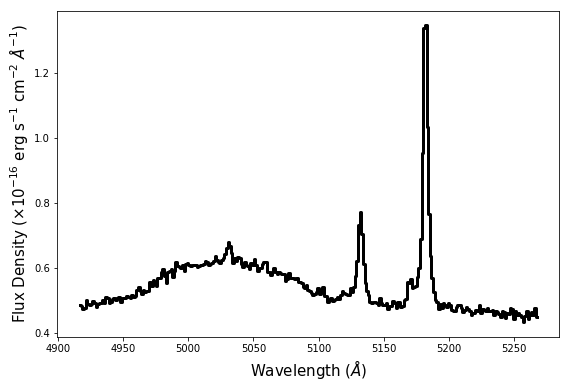

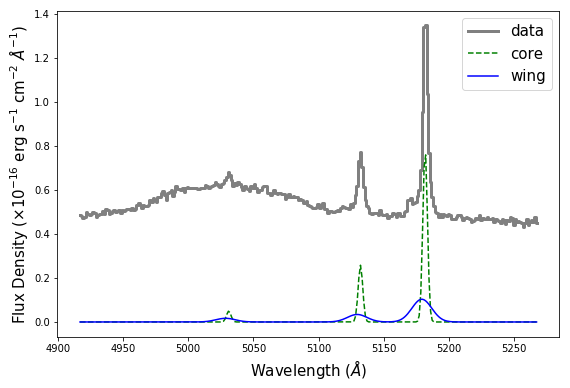

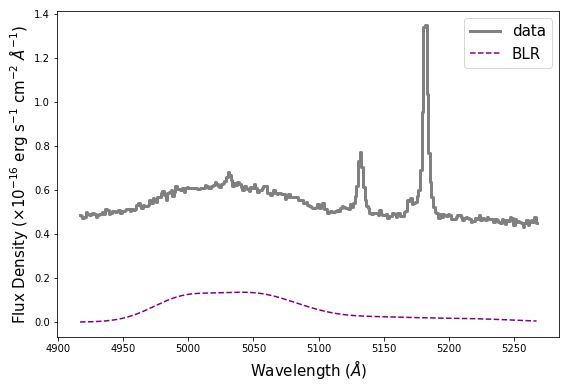

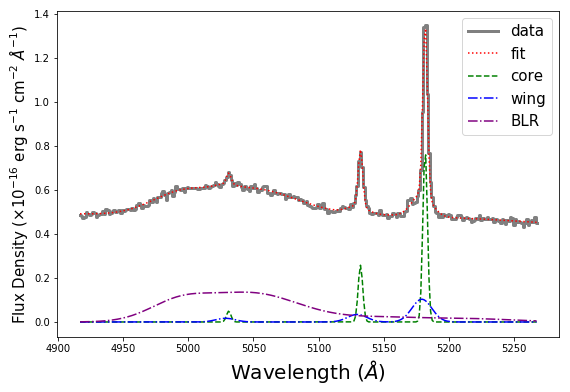

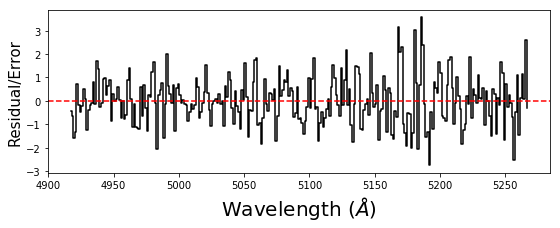

[199, 195]
HE1417-0909
41 45
2.4961486
[ 9.19917323e-01  1.31454743e+01  1.30870239e+04  6.43020791e+01
  1.55031643e-01  2.51474391e+00  1.30429263e+04  1.78039608e+02
  1.48641565e+00  1.73718588e-01  1.32271822e+04  1.46344165e+03
  0.00000000e+00  0.00000000e+00  1.32000000e+04  1.00000000e+03
 -7.96802206e-01  5.27721416e+00] [7.73478291e-02 2.46514285e-01 8.05682642e-01 1.70600102e+00
 5.87634972e-02 2.47932345e-01 3.88509955e+00 6.07018774e+00
 1.16828745e-02 6.31530108e-03 8.51731288e+00 1.23867648e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.08512880e-02 1.07245894e-01]


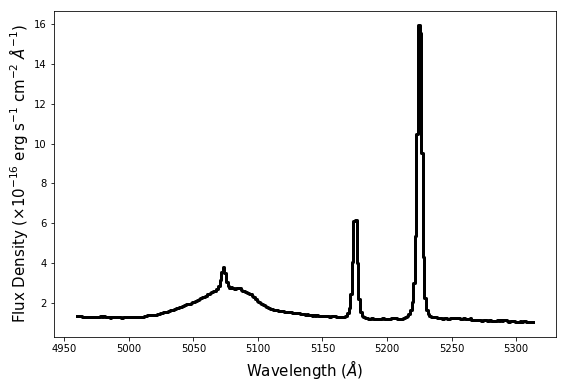

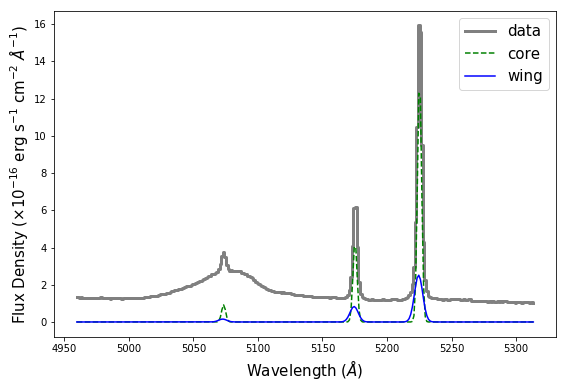

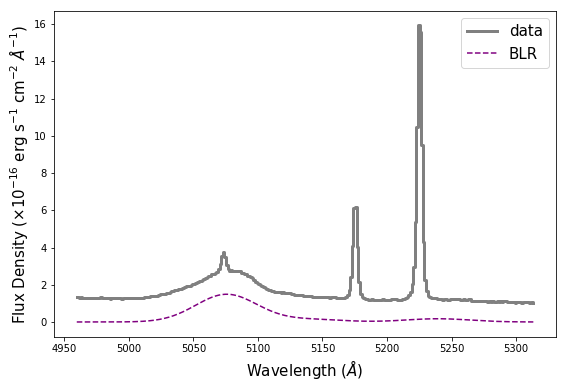

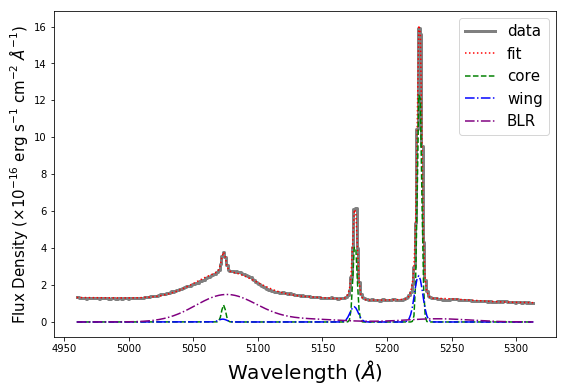

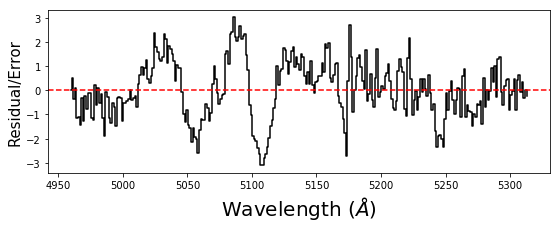

[41, 45]
HE0212-0059
160 157
6.7648897
[ 1.42678824e-01  2.09817309e+00  7.93048107e+03  1.64205036e+02
  4.07515972e-02  2.23983291e-01  7.64393461e+03  4.13211062e+02
  2.38285421e-01  6.54743169e-02  7.68548737e+03  3.72276645e+03
  9.51304646e-02  4.27574695e-02  4.62007969e+03  1.12476945e+03
 -2.09938136e-02  3.95284046e-01] [2.79029052e-02 7.77829495e-02 6.35991900e+00 7.08766510e+00
 2.14448802e-02 7.52402123e-02 7.25594150e+01 7.07386110e+01
 3.64471490e-02 2.13191240e-02 8.63371837e+02 6.12785325e+02
 4.12989851e-02 2.01371760e-02 2.73243323e+02 3.11378916e+02
 1.52213448e-01 7.94708972e-01]


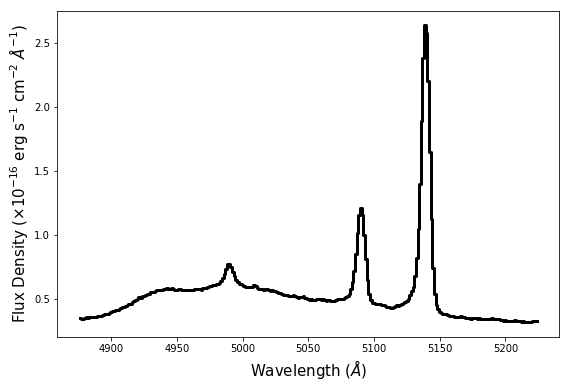

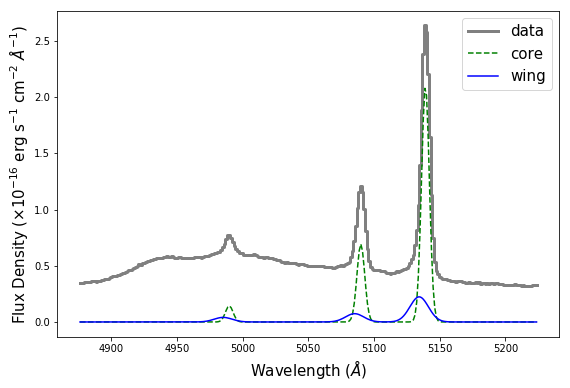

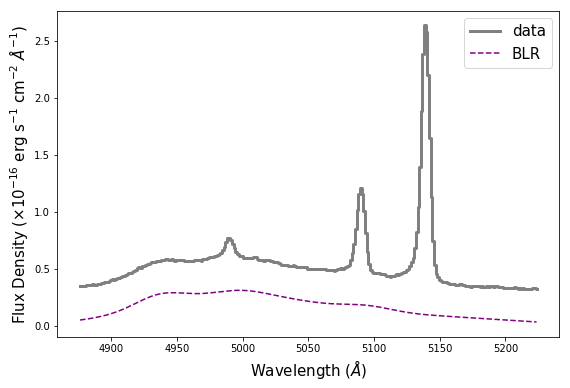

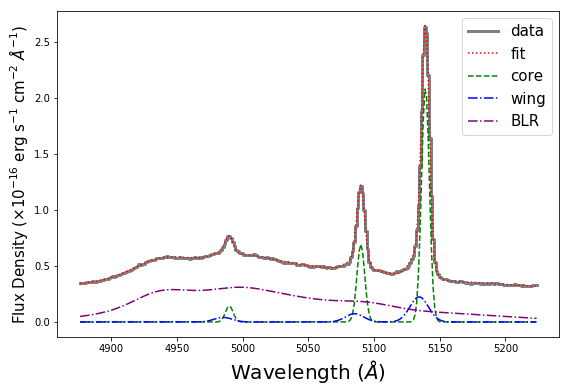

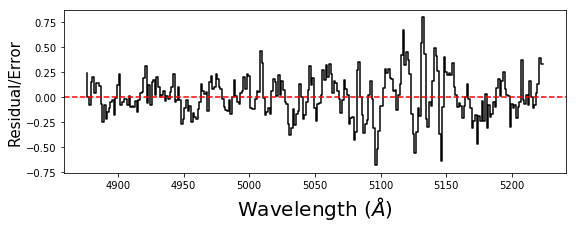

[160, 157]
HE1108-2813
158 152
0.7723302
[ 1.47822069e+00  3.23568179e+00  7.16152017e+03  7.21773837e+01
  7.42524535e-01  1.42840064e+00  7.03402435e+03  2.70675377e+02
  1.40805815e+00  3.94262017e-01  7.36335144e+03  1.31450720e+03
  0.00000000e+00  0.00000000e+00  7.20000000e+03  1.00000000e+03
 -3.62388600e-01  3.68624867e+00] [4.77356756e-02 6.00333322e-02 1.83490316e+00 2.57371050e+00
 3.44123885e-02 5.48879836e-02 4.99731124e+00 7.17031669e+00
 1.39885963e-02 6.73084284e-03 1.07510524e+01 1.01056600e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.10090546e-02 1.05679015e-01]


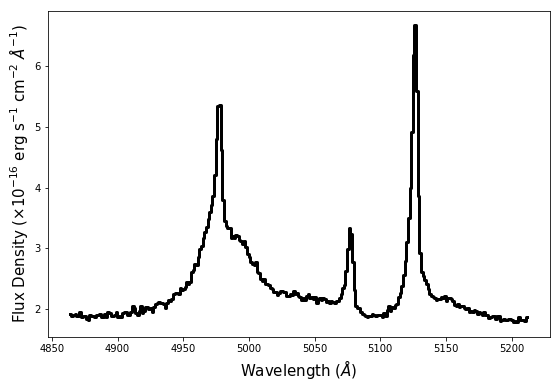

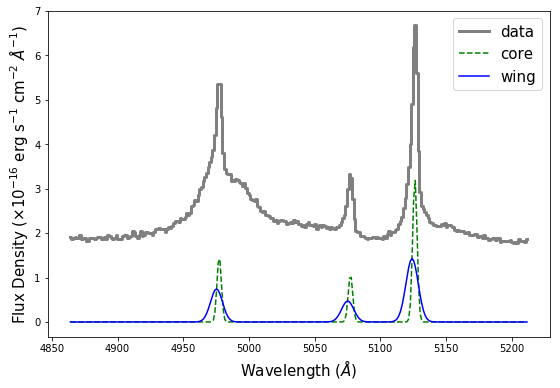

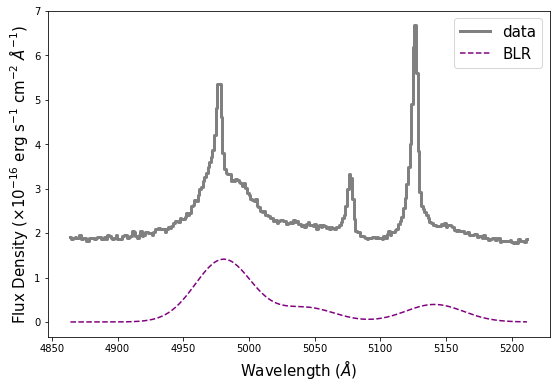

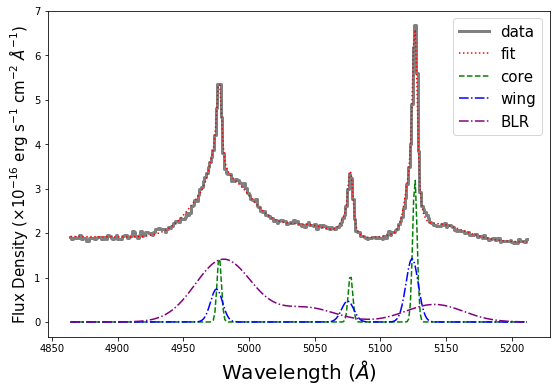

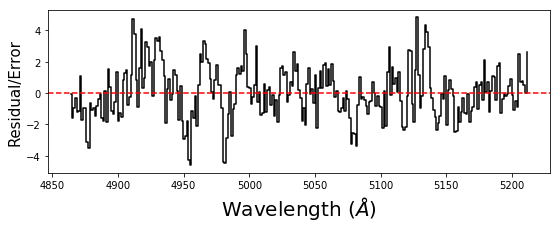

[158, 152]
HE0934+0119
155 163
0.8446844
[ 2.66461414e-01  1.82067548e+00  1.52083780e+04  6.92850367e+01
  1.85564344e-01  8.78873945e-01  1.50735467e+04  1.66338487e+02
  8.36823949e-01  1.19069948e-01  1.52092630e+04  5.86444252e+02
  3.62561306e-01  2.04871758e-02  1.52013596e+04  1.47488823e+03
 -1.35733055e-01  1.26884290e+00] [2.02932967e-02 5.19470504e-02 1.62934140e+00 2.68628476e+00
 2.45566385e-02 4.35745372e-02 7.91586676e+00 3.25480953e+00
 1.67663575e-02 3.89554734e-03 5.05375523e+00 1.62929976e+01
 2.48107726e-02 4.87066819e-03 1.28999131e+01 4.87003512e+01
 7.63396760e-03 3.94996121e-02]


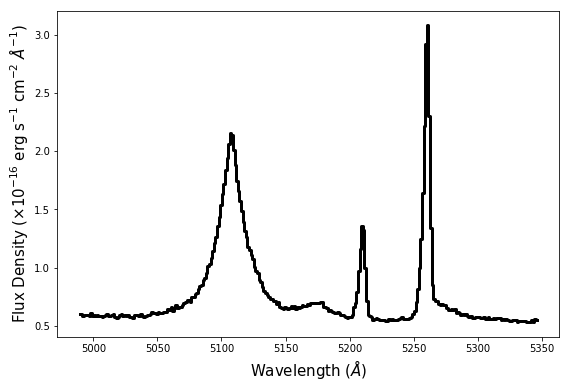

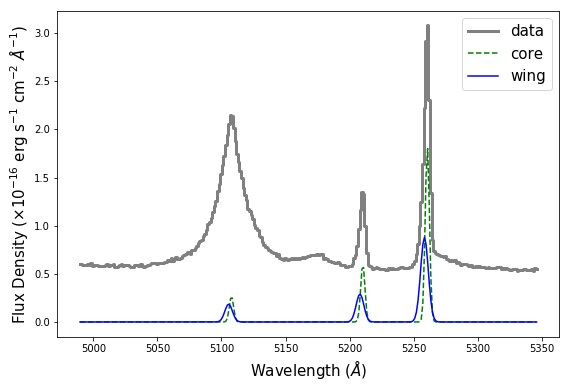

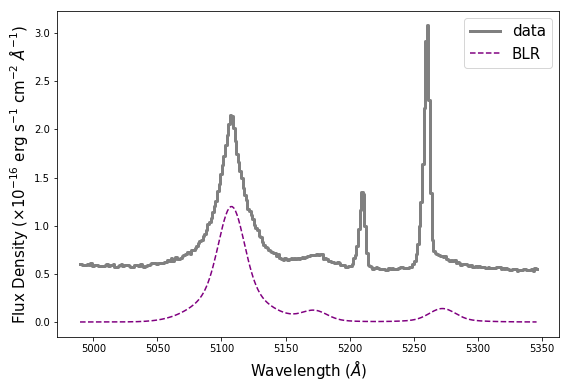

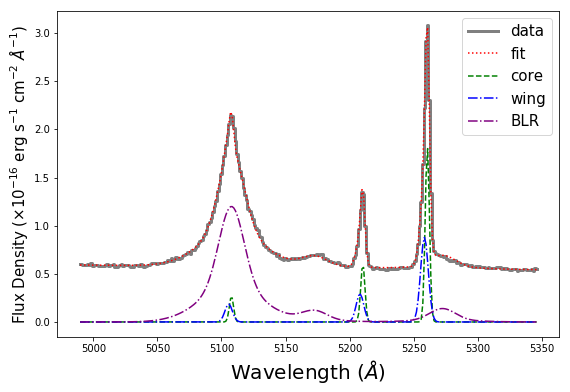

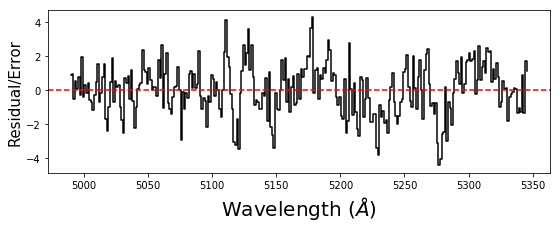

[155, 163]
HE1017-0305
87 109
1.1553473
[ 1.03271832e-01  1.49313177e+00  1.46793317e+04  4.60569013e+01
  7.04710862e-02  4.00981475e-01  1.46177440e+04  2.00249386e+02
  6.84568143e-01  6.98146565e-02  1.44802116e+04  1.96147641e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.33768567e-01  2.35401888e+00] [4.65208581e-02 5.67963681e-02 2.74830497e+00 5.81938388e+00
 3.67095334e-02 5.75088806e-02 1.13981346e+01 1.63706788e+01
 6.65463167e-03 4.91992139e-03 1.80023114e+01 2.15804055e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.67035480e-02 8.67194669e-02]


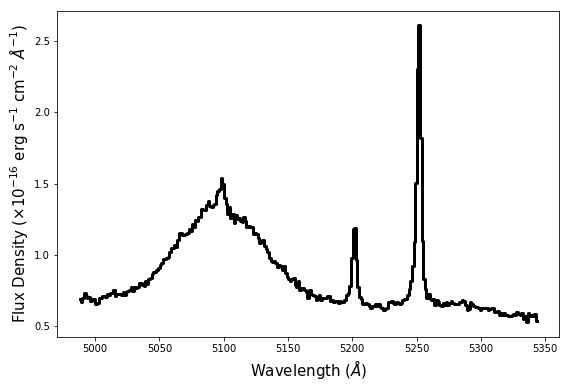

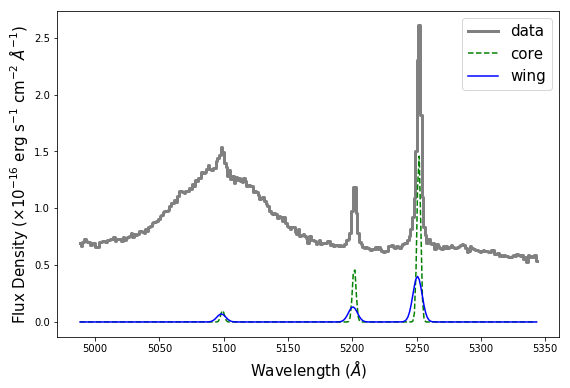

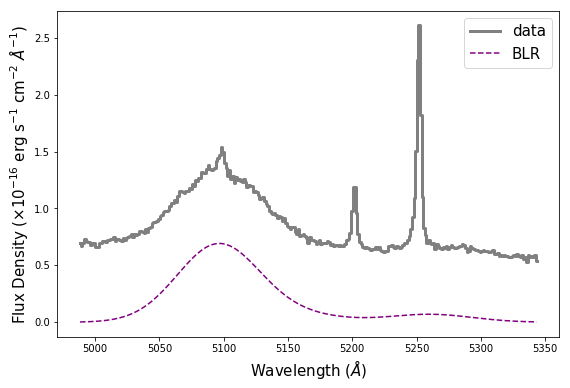

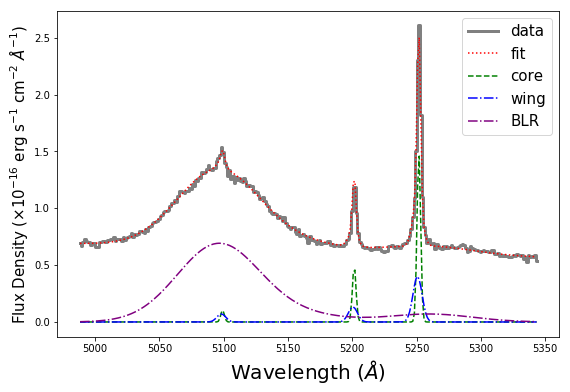

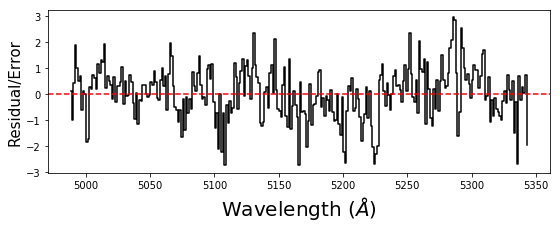

[87, 109]


In [7]:
z = {"HE0021-1810":0.05352,"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

objs = z.keys()

broad2= {'HE0021-1810':False,'HE0021-1819':False,'HE0040-1105':False,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0212-0059':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False
        ,'HE0253-1641':True,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True
        ,'HE0433-1028':True,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False
        ,'HE1029-1831':True,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1237-0504':False
        ,'HE1248-1356':False,'HE1330-1013':True,'HE1353-1917':True,'HE1417-0909':False,'HE2128-0221':False
        ,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':False}

p_init= {'HE0021-1810':[0.1,1.5248,16056,50.0,1.0,3.0,15956,100.0,1.0,1.0,16056,1000.0,0,0,16056,1000.0,-0.001,2.0]
        ,'HE0021-1819':[1,12.5,15959,50.0,3,3,15759,200.0,2,2,15959,1000.0,0,0,15959,1000.0,-0.001,0.1]
        ,'HE0040-1105':[1.139,1.5,12507.0,50.0,1.0,3.0,12307.0,200.0,1.0,1.0,12507,1000.0,0,0,12507,1000.0,-0.001,2.0]
        ,'HE0108-4743':[1.7,4.5,7160.0,40.0,0.12,2.5,7100.0,120.0,1.0,1.0,6960,1300.0,1.0,1.0,7190,430.0,-0.001,2.0]
        ,'HE0114-0015':[0.1,1.5,13680,50.0,1.0,3.0,13480,100.0,1.0,1.0,13680,1000.0,0,0,13680,1000.0,-0.001,0.3]
        ,'HE0119-0118':[1,12.5,16302,50.0,3,3,16102,100.0,2,2,16302,1000.0,1,1,16302,2500.0,-0.001,0.1]
        ,'HE0212-0059':[0.1,1.0,7930,170.0,0.1,0.1,7630,450.0,1.0,1.0,7620,4000.0,0.1,0.1,4650,1090.0,-0.001,2.0]
        ,'HE0224-2834':[0.2,2.5,17940,50.0,0.3,0.3,17640,200.0,0.1,0.1,17940,1500.0,0,0,17940,1500.0,-0.001,0.1]
        ,'HE0227-0913':[3,6,4785,150,2,7,4385,300.0,7,1.8,4935,400.0,3,0.5,4735,1500.0,-0.3,4.7]
        ,'HE0232-0900':[2,40,12942,50.0,5,5,12742,100.0,5,1,12942,1000.0,0,0,12942,1000.0,-0.001,0.1]                                     
        ,'HE0253-1641':[2,10,9476,110.0,1,6,9176,370.0,1,1,9476,1500.0,0.5,0.5,9476,550.0,-0.001,0.5]
        ,'HE0345+0056':[0.5,20,9300,150,5,10,9000,300,9,1.8,9300,400,30,2.5,9300,1500,0.3,7.1]
        ,'HE0351+0240':[2.2,37,10600,77,1.1,1.5,10618,277,1.5,0.07,11580,320,3,0.35,10650,1344,-0.3,3]                                                    
        ,'HE0412-0803':[1.139,1.5,11448,50.0,0.1,0.3,11248,100.0,0.1,0.1,11448,1000.0,0,0,11448,1000.0,-0.001,0.5]
        ,'HE0429-0247':[0.9,8.5,12600,90,0.2,2.0,12500,220,1.7,0.07,12600,450,1.3,0.2,12600,1600,-0.5,4.0]
        ,'HE0433-1028':[0.9,4.0,10665.0,100.0,1.0,1.0,10465.0,300.0,1.0,1.0,10665,800.0,0.1,0.1,10665,1500.0,-0.1,1.0]
        ,'HE0853+0102':[0.1,0.9,15700,110.0,0.02,0.3,15670,320.0,0.1,0.1,15900,1640.0,0.0,0.0,17250,810.0,-0.001,0.1]
        ,'HE0934+0119':[0.6,1.9,15101,100.0,0.2,0.2,14901,400.0,0.3,0.1,15101,1000.0,0.1,0.1,15101,1000.0,0.001,0.7]
        ,'HE1011-0403':[0.1,0.6,17494,60.0,0.2,0.2,17244,200.0,0.3,0.1,17494,1500.0,0.1,0.1,17494,1500.0,0.001,0.7]
        ,'HE1017-0305':[0.1,1.5,14695,50,0.08,0.4,14595,200,0.7,0.09,14695,2000,0,0,0,0,-0.3,2.0]
        ,'HE1029-1831':[0.6,1.3,12078,50.0,0.2,0.2,11978,200.0,0.3,0.1,12078,1000.0,0.2,0.2,12078,1000.0,-0.001,0.2]
        ,'HE1107-0813':[0.04,0.3,17500,100,0.2,0.13,17400,480,0.9,0.13,17500,1000,0.9,0.08,16800,2000,-0.9,8]
        ,'HE1108-2813':[1.139,1.5,7200.0,50.0,1.0,3.0,7000.0,100.0,1.0,1.0,7200,1000.0,0,0,7200,1000.0,-0.001,2.0]
        ,'HE1126-0407':[1,13,18200,100,2.5,3,18000,300,10,1.3,18200,800,7,1.8,18200,1600,-0.9,15]
        ,'HE1237-0504':[1,10,2700.0,80.0,0.5,2,2700.0,200,2,0.5,2700.0,1500.0,0,0,2700.0,1000.0,-0.001,0.002]
        ,'HE1248-1356':[0.1,1.5,4395.0,50.0,1.0,3.0,4195.0,100.0,1.0,1.0,4395,1000.0,0,0,0,0.0,-0.001,2.0]
        ,'HE1330-1013':[0.15,0.6,6643,90,0.05,0.15,6543,200,0.12,0.04,6643,1500,0.3,0.04,6643,500,-0.02,0.3]
        ,'HE1353-1917':[0.07,0.7,10490.0,80.0,0.39,0.05,10306.0,490.0,0.1,0.02,8600.0,1500.0,0.14,0.02,12326.0,1500.0,-0.001,0.002]
        ,'HE1417-0909':[1,12.5,13200,50.0,3,3,13000,100.0,2,2,13200,1000.0,0,0,13200,1000.0,-0.001,0.1]
        ,'HE2128-0221':[0.1,1.5,15744,50.0,1.0,3.0,15544,100.0,1.0,1.0,15744,1000.0,0,0,15744,1000.0,-0.001,2.0]
        ,'HE2211-3903':[0.6,2.4,11914,50.0,0.1,0.1,11714,100.0,0.1,0.1,11914,200.0,0,0,11914,100.0,-0.001,0.2]
        ,'HE2222-0026':[0.08,0.4,17400.0,140.0,0.04,0.05,17150.0,300.0,0.4,0.1,18500,650.0,0.02,0.01,17460,1750.0,-0.001,0.002]
        ,'HE2233+0124':[0.1,1.2,16944.0,100.0,1.0,3.0,17044.0,300.0,1.0,1.0,16944,1200.0,1.0,1.0,16944,4000.0,-0.001,2.0]
        ,'HE2302-0857':[1,8,14058,200,0.1,2,14258,300,1,0.1,14058,1000,0,0,0,0,0.01,0.2]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 


In [ ]:
z = {"HE0021-1810":0.05352}

objs = z.keys()

broad2= {'HE0021-1810':False}

p_init= {'HE0021-1810':[0.1,1.5248,16056,50.0,1.0,3.0,15965,100.0,0.1,0.1,15956,1000.0,0.01,0.01,16056,2000.0,-0.001,2.0]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 


HE0021-1810
80 75
2.3589199
[0.01712498 0.01712467 0.01680785 0.01674415 0.01663852 0.0162886
 0.01633794 0.01629646 0.01632132 0.01624171 0.01628794 0.016376
 0.01679873 0.01687782 0.01659747 0.01716186 0.01701536 0.01818757
 0.02062981 0.02115675 0.01943783 0.02061383 0.02042657 0.02034963
 0.02183881 0.02227416 0.02161558 0.02138111 0.02227777 0.02217691
 0.02311499 0.02242783 0.02263331 0.02334789 0.02208283 0.02230916
 0.02323872 0.02314904 0.02171901 0.02168793 0.02133467 0.02059152
 0.02001073 0.01959697 0.02078597 0.01976798 0.01916344 0.01809856
 0.01777528 0.01801896 0.01841403 0.01749815 0.0174551  0.01738985
 0.01727171 0.0167621  0.01687691 0.01700248 0.01707605 0.01748766
 0.01762243 0.01744453 0.01762117 0.01787294 0.01849534 0.01918468
 0.01895835 0.01973121 0.01986073 0.02090972 0.02101212 0.02169262
 0.02334568 0.02351597 0.02363044 0.02388256 0.02366047 0.024795
 0.0242488  0.02413482 0.02446118 0.02482186 0.02404524 0.02474602
 0.02467664 0.0248848  0.02485848 0.024